<a href="https://colab.research.google.com/github/stayxyz/CreditAnalytics/blob/master/Formal_Banking_Coursework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix B



Part I & II 
https://colab.research.google.com/drive/1TzzZciYVds_JyGNTstfE82Pe7he0E3P0  \
Part III
https://colab.research.google.com/drive/1WwVhkoyVTgOyf_GARuucu1otgpZofuW0

# Part I Understanding Data & Data Processing 

Download the Data 

In [ ]:
!gdown https://drive.google.com/uc?id=1HAItdPa8TP-09OLSQ-Z5z3T_UbMp5mrt
!unzip '/content/Coursework 2 - Lending Club Data.zip'


Downloading...
From: https://drive.google.com/uc?id=1HAItdPa8TP-09OLSQ-Z5z3T_UbMp5mrt
To: /content/Coursework 2 - Lending Club Data.zip
369MB [00:03, 102MB/s] 
Archive:  /content/Coursework 2 - Lending Club Data.zip
  inflating: LCFinal.csv             
  inflating: Variable Dictionary.docx  


In [ ]:
## checking if file is correct 
!head LCFinal.csv
 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg

Initializing all the packages for doing data processing 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
Loan_data = pd.read_csv('LCFinal.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,17,47,56,115,126,127,128,131,132,133,136,142,143,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Checking the data size
Loan_data.shape

(2260701, 148)

## Clean from from first impression

In [ ]:
#We delete useless rows where loan amount is Null

#Find the subset of the Loan where loan amount is Null 
nan_rows = Loan_data[Loan_data['loan_amnt'].isnull()]
#Drop those rows 
Loan_data = Loan_data.drop(nan_rows.index)

In [ ]:
#Drop the irrelevent variables for credit scoring and LGD Modelling 
#from our first impression


#The drop list are irrelevent text columns so drop them from the beginning
drop_list_round1 = ['id','member_id', 'url', 'desc', 'emp_title', 'issue_d',\
                    'last_pymnt_d', 'next_pymnt_d', 'initial_list_status',
                    'verification_status_joint', 'disbursement_method']
Loan_data = Loan_data.drop(drop_list_round1, axis = 1)
Loan_data = Loan_data.drop(Loan_data.columns[0], axis = 1)

In [ ]:
#Modify Zip Code
Loan_data.loc[Loan_data['zip_code'] != np.nan, 'zip_code'] = \
Loan_data.loc[Loan_data['zip_code'] != np.nan, 'zip_code'].str[0]

len(list(Loan_data['zip_code'].unique()))

11

In [ ]:
len(list(Loan_data['addr_state'].unique()))

51

Because the State values are far less than zip_code, so we can drop the zip code while they both represents address

In [ ]:
Loan_data = Loan_data.drop('addr_state', axis = 1)

In [ ]:
Loan_data.shape

(2260668, 135)

## Constructing our objective variables 

###Scorecard Objective 

In [ ]:
#For Credit Scoring our objective variable is loan_status
#For LGD Modelling, we only cosider defaulted cases which means that loan_status
#is "charged_off"

#First we check how many unique value are in the objective variable:
Loan_data['loan_status'].value_counts()



Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Because we only want binary results "Good" & "Bad" for Credit Scoring, the main groups matches "Good" and "Bad" are [Fully paid] and [Charged Off]. 


We also have the cases where is status is "Current", "Late","In Grace Period","default".

For "Current", "In Grace Period", "Late (16-30 days)" We can still consider it as "Good" cases because the PD for those cases are really low, and they do not belong to any defination of default we have learned in this course. As for "Late (31-120 days)" & "Default", I condisder it as "Bad" Cases because the PD is pretty high in these cases

As for the rest of the groups "Does not meet the credit policy. Status:Fully Paid", "Does not meet the credit policy. Status:Charged Off", since they will not be allowed to enter application anymore, we can just discard them. Besides, it kind of revealed Loan Club's credit scoring system, which is not desired.

In [ ]:
##Now we map all those values into "0" (good) and "1" (bad)

Loan_data.loc[Loan_data['loan_status'] == 'Fully Paid', 'loan_status'] = 0
Loan_data.loc[Loan_data['loan_status'] == 'Current', 'loan_status'] = 0
Loan_data.loc[Loan_data['loan_status'] == 'In Grace Period', 'loan_status'] = 0
Loan_data.loc[Loan_data['loan_status'] == 'Late (16-30 days)','loan_status'] = 0


Loan_data.loc[Loan_data['loan_status'] == 'Late (31-120 days)','loan_status']=1
Loan_data.loc[Loan_data['loan_status'] == 'Charged Off','loan_status']=1
Loan_data.loc[Loan_data['loan_status'] == 'Default','loan_status']=1


In [ ]:
#And Discard those ones which are out of policy
drop_out_policy1 = Loan_data.loc[Loan_data['loan_status'] == 
                'Does not meet the credit policy. Status:Fully Paid'].index

drop_out_policy2 = Loan_data.loc[Loan_data['loan_status'] == 
                'Does not meet the credit policy. Status:Charged Off'].index

Loan_data = Loan_data.drop(drop_out_policy1, axis = 0)
Loan_data = Loan_data.drop(drop_out_policy2, axis = 0)

In [ ]:
Loan_data['loan_status'].value_counts()

0    1967853
1     290066
Name: loan_status, dtype: int64

In [ ]:
Lenth_default = 290066

### LGD Variable

In [ ]:
Loan_data['LGD'] = 1- ((Loan_data['recoveries'] + Loan_data['total_rec_late_fee'] - \
                        Loan_data['collection_recovery_fee']) \
                       / (Loan_data['funded_amnt']  - Loan_data['total_rec_prncp']))


In [ ]:
Loan_data['LGD'].fillna(0, inplace = True)
## Add lower and upper cap 0 and 1 respectively
Loan_data.loc[Loan_data['LGD'] < 0, 'LGD'] = 0
Loan_data.loc[Loan_data['LGD'] > 1, 'LGD'] = 1

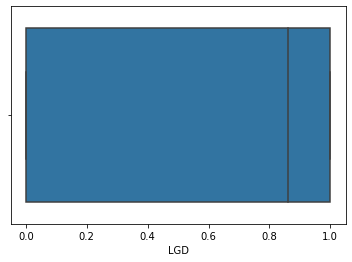

In [ ]:
## Check transformation is coorect 
sns.boxplot(Loan_data['LGD'])

In [ ]:
## Since our LGD is constructed by the following variables 
## we have to drop them to avoid collieaity 

Loan_data = Loan_data.drop(['recoveries', 'total_rec_late_fee', \
                            'collection_recovery_fee', 'funded_amnt',
                            'total_rec_prncp'], axis = 1)


## Dealing with Missing Data

In [ ]:
nullset = Loan_data.isnull()
null_counts = Loan_data.isnull().sum() / len(Loan_data)
print("percentage of null values in each column:\n{}".format(null_counts.head(143)))

percentage of null values in each column:
loan_amnt                0.000000
funded_amnt_inv          0.000000
term                     0.000000
int_rate                 0.000000
installment              0.000000
                           ...   
settlement_date          0.984837
settlement_amount        0.984837
settlement_percentage    0.984837
settlement_term          0.984837
LGD                      0.000000
Length: 131, dtype: float64


In [ ]:
Missing_columns = list(null_counts.loc[null_counts.head(143) > 0].index)
len(Missing_columns)

#So we have 99 columns that have missing values

99

### Dealing those variables that have too many missing values with careful investigation

Our principle is: 
"Delete - Keep - Replace"

In [ ]:
Missing_column_Big_o = list(null_counts.loc[null_counts.head(137) > 0.9].index)
Missing_column_Big = Missing_column_Big_o
Missing_column_Big


['annual_inc_joint',
 'dti_joint',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

Notice that most of those massive missing columns are clustering with key words 'settlement', 'hardship' and 'sec_app'. 

#### Dealing with sec_app group

"Sec_app" have too many missing values, Therefore it is useless to be analyzed

Because 'sec_app' variables would have values if and only if the applicant has a secondary applicant. From the data, we can see 98% of applicant doesn't have a sec_applicant, therefore it is useless to analyze those values even if some of them are closely related to PD and LGD. 

Conclusion: drop them all 

In [ ]:
drop_list_round2 = ['sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_mths_since_last_major_derog',
 'sec_app_collections_12_mths_ex_med', 
 'sec_app_chargeoff_within_12_mths']
Loan_data = Loan_data.drop(drop_list_round2, axis = 1)

In [ ]:
Loan_data.shape

(2257919, 119)

#### Dealing with hardship

Similar to "Sec_app", "hardship" variables are clustering. Which means we only need to keep the most useful one to indicate the exsitence of hardship and the information that variable contains. NaN means the hardship does not exist.

And this information is only probably useful in LGD

In this case, I choose 'hardship_amnt' as the representive variable for 'hard_ship" group and drop the rest 

In [ ]:
Loan_data['hardship_amount'].value_counts()

69.90     5
48.56     5
53.05     5
132.33    5
94.59     5
         ..
494.35    1
62.04     1
62.21     1
21.22     1
243.11    1
Name: hardship_amount, Length: 9162, dtype: int64

In [ ]:
Loan_data[Loan_data['hardship_amount'].isin([0])]

##Since there is no value "0" in 'hardship_amount', we can use 0 to fill NaNs
##to indicate those rows with no hardship

Loan_data['hardship_amount'].fillna(0, inplace = True)

## Now we can drop the rest of the "hard_ship" cluster 

drop_list_round3 = ['hardship_type','hardship_reason','hardship_status',
 'deferral_term','hardship_start_date','hardship_end_date',
 'payment_plan_start_date','hardship_length','hardship_dpd',
 'hardship_loan_status','orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount','hardship_last_payment_amount',]

Loan_data = Loan_data.drop(drop_list_round3, axis = 1)

In [ ]:
Missing_column_Big = list(set(Missing_column_Big)\
                          - set(['hardship_amount']))

#### Deal with Settlement 

Since settlement clusters are included in the recoverie and settlements obervations are missing more than 90% of values. Although they are related to LGD, but they only accounts 10% of the defaulted cases. I decide to drop them

In [ ]:
Loan_data['settlement_amount'].notnull().sum() / Lenth_default

## They only accounts 10% of defaulted cases 

0.11802831079823213

In [ ]:
Settlement = ['settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term', 
 'debt_settlement_flag_date']

Loan_data = Loan_data.drop(Settlement, axis = 1)

Missing_column_Big = list(set(Missing_column_Big) - set(Settlement))

In [ ]:
removed = drop_list_round2 + drop_list_round3
Missing_column_Big = list(set(Missing_column_Big) - set(removed))
Missing_column_Big


['annual_inc_joint', 'revol_bal_joint', 'dti_joint']

#### Dealing With Joint Application Type

Related Variables: 'revol_bal_joint', 'annual_inc_joint', 'dti_joint', 'verification_status_joint'

Notice that all the variables are related to joint account, and I found that if these variables are NaN, then it means individual application. Since these variables have less than 10% of data, I decide to drop them all 



In [ ]:
drop_list_round4 = ['revol_bal_joint', 'annual_inc_joint', 'dti_joint']
Loan_data = Loan_data.drop(drop_list_round4, axis = 1)

In [ ]:
Missing_column_Big = list(set(Missing_column_Big) - set(drop_list_round4))
Missing_column_Big

[]

Now we have finished clean data that has greater than 90% of the data, Lets check medium amount of missing values: 

In [ ]:
null_counts2 = Loan_data.isnull().sum() / len(Loan_data)
Missing_column_Medium = list(null_counts2.loc[null_counts2.head(137) > 0.5].index)
Missing_column_Medium

['mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq']

 #### Dealing With important indictor of PD & LGD 
 ['mths_since_recent_revol_delinq','mths_since_last_major_derog','mths_since_recent_bc_dlq','mths_since_last_delinq', 'mths_since_last_record']

 They are important indicator of PD and LGD, NaN means no record or never had bad records recently. so we try to fill NaN Values with something out of range, I used -1 to represent this information, and treat them as NaN 

In [ ]:
Loan_data.loc[Loan_data['mths_since_recent_revol_delinq'].isnull() == True, 'mths_since_recent_revol_delinq'] = -1

In [ ]:

Loan_data.loc[Loan_data['mths_since_last_major_derog'].isnull() == True, 'mths_since_last_major_derog'] = -1

In [ ]:

Loan_data.loc[Loan_data['mths_since_recent_bc_dlq'].isnull() == True, 'mths_since_recent_bc_dlq'] = -1

In [ ]:
Loan_data.loc[Loan_data['mths_since_last_delinq'].isnull() == True, 'mths_since_last_delinq'] = -1

In [ ]:
Loan_data.loc[Loan_data['mths_since_last_record'].isnull() == True,  'mths_since_last_record'] = -1

In [ ]:
bad_record =  ['mths_since_recent_revol_delinq','mths_since_last_major_derog','mths_since_recent_bc_dlq','mths_since_last_delinq', 'mths_since_last_record']
Missing_column_Medium = list(set(Missing_column_Big) - set(bad_record))
Missing_column_Medium

[]

### Dealling with small portion of the data are missing



In [ ]:
Missing_column_Small = list(null_counts2.loc[null_counts2.head(137) <= 0.5].index)
Missing_column_Small

for i in Missing_column_Small:
  print (str(i) + "       " + str(Loan_data[i].isnull().sum() / len(Loan_data)))


loan_amnt       0.0
funded_amnt_inv       0.0
term       0.0
int_rate       0.0
installment       0.0
emp_length       0.06504794901854317
home_ownership       0.0
annual_inc       0.0
loan_status       0.0
pymnt_plan       0.0
purpose       0.0
title       0.010329422800375035
zip_code       4.428856836759866e-07
dti       0.0007577774047696131
delinq_2yrs       0.0
earliest_cr_line       0.0
fico_range_low       0.0
fico_range_high       0.0
inq_last_6mths       4.428856836759866e-07
open_acc       0.0
pub_rec       0.0
revol_bal       0.0
revol_util       0.0007803645746370884
total_acc       0.0
out_prncp       0.0
out_prncp_inv       0.0
total_pymnt       0.0
total_pymnt_inv       0.0
total_rec_int       0.0
last_pymnt_amnt       0.0
last_credit_pull_d       3.100199785731906e-05
last_fico_range_high       0.0
last_fico_range_low       0.0
collections_12_mths_ex_med       2.480159828585525e-05
application_type       0.0
acc_now_delinq       0.0
tot_coll_amt       0.029906741561588

In [ ]:
Loan_data.shape

(2257919, 97)

#### Replace all missing cells is the missing portion is smaller than 3%

In [ ]:
Missing_column_Small = list(null_counts2.loc[(null_counts2.head(115) < 0.5) & 
                                             (null_counts2.head(115) > 0)].index)
Missing_column_small_o = list(null_counts2.loc[(null_counts2.head(115) < 0.03) &  
                                               (null_counts2.head(115) > 0)].index)
Missing_column_small_o

['title',
 'zip_code',
 'dti',
 'inq_last_6mths',
 'revol_util',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'chargeoff_within_12_mths',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

In [ ]:
for i in Missing_column_small_o:
  if Loan_data[i].dtype == 'float64':
    median = Loan_data[i].median()
    Loan_data[i].fillna(median, inplace=True)
  elif Loan_data[i].dtype == 'O':
    mode = Loan_data[i].mode()[0]
    Loan_data[i].fillna(mode, inplace=True)

In [ ]:
## Update the miss_value list 
Missing_column_Small = list(set(Missing_column_Small) - set(Missing_column_small_o))

for i in Missing_column_Small:
  print (str(i) + "       " + str(Loan_data[i].isnull().sum() / len(Loan_data)))

emp_length       0.06504794901854317
max_bal_bc       0.38237864157217333
all_util       0.38247563353689834
inq_fi       0.38237864157217333
bc_open_to_buy       0.03197014596183477
total_bal_il       0.38237864157217333
bc_util       0.03247326409849069
open_rv_12m       0.38237864157217333
open_rv_24m       0.38237864157217333
open_act_il       0.38237864157217333
total_cu_tl       0.382379084457857
open_il_12m       0.38237864157217333
open_acc_6m       0.382379084457857
mo_sin_old_il_acct       0.06037506217007785
percent_bc_gt_75       0.032166787205386904
mths_since_recent_bc       0.03129563106559624
open_il_24m       0.38237864157217333
il_util       0.472160870252653
mths_since_rcnt_il       0.40177482008876314
inq_last_12m       0.382379084457857
num_tl_120dpd_2m       0.06683499275217579
mths_since_recent_inq       0.1296264392123898


These columns seems pretty important, So we will test correlation among them and hopefully we can eliminate down to a narrower list  





## Correlation Analysis & Filtering 

Our basic principle is to drop variables that has a correlation which has greater than 70%

In [ ]:
Loan_data.shape

(2257919, 97)

Now we split the variables into three parts to further reduce variables 

In [ ]:
##Define a function to sort correlation 
##Get diagonal and lower triangular pairs of correlation matrix
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

## Get 

def get_top_abs_correlations(df, n=100):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


In [ ]:
min_obs = int(0.5 * len(Loan_data))
min_obs 

1128959

In [ ]:
%%script false
df_part1 = Loan_data.iloc[:,0:35]
corelation_part1 = df_part1.corr(method = 'spearman', min_periods = min_obs)

In [ ]:
%%script false
get_top_abs_correlations(corelation_part1, 35)

fico_range_low          fico_range_high         1.000000
last_fico_range_high    last_fico_range_low     1.000000
out_prncp               out_prncp_inv           1.000000
total_pymnt             total_pymnt_inv         0.999999
loan_amnt               funded_amnt_inv         0.999996
mths_since_last_record  pub_rec                 0.999788
loan_amnt               installment             0.996860
funded_amnt_inv         installment             0.996794
open_acc                total_acc               0.921634
total_pymnt             last_pymnt_amnt         0.882018
total_pymnt_inv         last_pymnt_amnt         0.881919
installment             total_rec_int           0.875587
loan_amnt               total_rec_int           0.859182
funded_amnt_inv         total_rec_int           0.858857
total_pymnt_inv         total_rec_int           0.847995
total_pymnt             total_rec_int           0.847633
installment             total_pymnt_inv         0.827813
                        total_p

In [ ]:
##From our first round correlation filtering, we drop the following variables
new_drop_list1 = ['last_fico_range_high', 'fico_range_high', 'out_prncp_inv', 
                  'funded_amnt_inv', 'open_acc', 'total_pymnt_inv', 
                  'pub_rec', 'mths_since_last_delinq', 'last_pymnt_amnt',
                  'fico_range_low']

In [ ]:
 
df_part2 = Loan_data.iloc[:,35:71]
corelation_part2 = df_part2.corr(method = 'spearman', min_periods = min_obs)

In [ ]:
 
get_top_abs_correlations(corelation_part2, 60)

open_acc_6m                  mo_sin_rcnt_tl                    0.994186
open_il_12m                  mths_since_rcnt_il                0.992825
open_rv_12m                  mo_sin_rcnt_rev_tl_op             0.987563
                             open_rv_24m                       0.971694
mths_since_recent_bc_dlq     mths_since_recent_revol_delinq    0.970329
open_il_24m                  mths_since_rcnt_il                0.969903
open_rv_12m                  mths_since_recent_bc              0.966719
acc_now_delinq               delinq_amnt                       0.962148
mo_sin_rcnt_rev_tl_op        mths_since_recent_bc              0.961657
open_il_12m                  open_il_24m                       0.957778
tot_cur_bal                  avg_cur_bal                       0.956411
open_act_il                  total_bal_il                      0.950963
open_rv_24m                  mths_since_recent_bc              0.949524
                             mo_sin_rcnt_rev_tl_op             0

In [ ]:
new_drop_list2 = ['open_acc_6m','open_il_12m', 'mths_since_rcnt_il', 
                  'mths_since_recent_bc_dlq', 'open_rv_12m', 
                  'mths_since_recent_bc','avg_cur_bal','total_bal_il',
                  'inq_last_12m','bc_open_to_buy','inq_last_12m','bc_util']


In [ ]:

df_part3 = Loan_data.iloc[:,71:106]
corelation_part3 = df_part3.corr(method = 'spearman', min_periods = min_obs)

In [ ]:

get_top_abs_correlations(corelation_part3, 60)

num_actv_rev_tl        num_rev_tl_bal_gt_0           0.999921
num_actv_bc_tl         num_bc_sats                   0.962183
num_bc_tl              num_rev_accts                 0.958566
num_actv_bc_tl         num_actv_rev_tl               0.947868
                       num_rev_tl_bal_gt_0           0.946914
total_bal_ex_mort      total_il_high_credit_limit    0.944701
num_op_rev_tl          num_rev_tl_bal_gt_0           0.942961
num_actv_rev_tl        num_op_rev_tl                 0.942959
num_op_rev_tl          num_rev_accts                 0.940419
num_bc_sats            num_op_rev_tl                 0.936511
                       num_bc_tl                     0.928353
num_op_rev_tl          num_sats                      0.913517
num_bc_tl              num_op_rev_tl                 0.905561
num_accts_ever_120_pd  pct_tl_nvr_dlq                0.904416
num_actv_bc_tl         num_op_rev_tl                 0.903647
num_il_tl              total_il_high_credit_limit    0.901092
num_actv

In [ ]:
new_drop_list3 = ['num_actv_rev_tl','num_bc_sats','num_bc_tl',
                  'num_rev_accts','num_sats','pct_tl_nvr_dlq',
                  'num_il_tl']


In [ ]:
Total_drop_list1 = new_drop_list1 + new_drop_list2 + new_drop_list3

In [ ]:
Loan_data = Loan_data.drop(Total_drop_list1, axis = 1)

In [ ]:
Loan_data.shape

(2257919, 69)

In [ ]:
Loan_data.head(1)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,purpose,title,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_record,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_credit_pull_d,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,open_il_24m,il_util,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_amount,debt_settlement_flag,LGD
0,3600.0,36 months,13.99,123.03,10+ years,MORTGAGE,55000.0,0,n,debt_consolidation,Debt consolidation,1,5.91,0.0,Aug-2003,1.0,-1.0,2765.0,29.7,13.0,0.0,4421.723917,821.72,Mar-2019,560.0,0.0,30.0,Individual,0.0,722.0,144904.0,2.0,1.0,36.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,2.0,2.0,4.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,0.0,N,0.0


In [ ]:

df_part4 = Loan_data.iloc[:,0:41]
corelation_part4 = df_part4.corr(method = 'spearman', min_periods = min_obs)
get_top_abs_correlations(corelation_part4, 50)


loan_amnt            installment             0.997649
revol_bal            max_bal_bc              0.965967
open_rv_24m          acc_open_past_24mths    0.886899
total_pymnt          total_rec_int           0.885693
installment          total_rec_int           0.876348
                     total_pymnt             0.871124
loan_amnt            total_rec_int           0.866227
                     total_pymnt             0.859289
revol_bal            total_rev_hi_lim        0.807593
annual_inc           tot_cur_bal             0.761272
max_bal_bc           total_rev_hi_lim        0.753032
revol_util           all_util                0.751703
int_rate             last_fico_range_low     0.747663
open_act_il          open_il_24m             0.744679
loan_amnt            revol_bal               0.694297
open_il_24m          acc_open_past_24mths    0.693971
loan_amnt            annual_inc              0.689122
installment          revol_bal               0.683262
annual_inc           total_r

In [ ]:
new_drop_list4 = ['revol_bal', 'acc_open_past_24mths', 'installment',
                  'int_rate', 'revol_util']

In [ ]:

df_part5 = Loan_data.iloc[:,41:81]
corelation_part5= df_part5.corr(method = 'spearman', min_periods = min_obs)
get_top_abs_correlations(corelation_part5, 50)

mo_sin_rcnt_tl                  num_tl_op_past_12m            0.962573
mo_sin_rcnt_rev_tl_op           mo_sin_rcnt_tl                0.956591
num_actv_bc_tl                  num_rev_tl_bal_gt_0           0.954759
num_op_rev_tl                   num_rev_tl_bal_gt_0           0.953200
total_bal_ex_mort               total_il_high_credit_limit    0.952145
mo_sin_rcnt_rev_tl_op           num_tl_op_past_12m            0.934788
delinq_amnt                     num_tl_30dpd                  0.926013
num_actv_bc_tl                  num_op_rev_tl                 0.903193
mort_acc                        tot_hi_cred_lim               0.828736
tot_hi_cred_lim                 total_bal_ex_mort             0.804227
num_actv_bc_tl                  total_bc_limit                0.750487
tot_hi_cred_lim                 total_il_high_credit_limit    0.714925
num_op_rev_tl                   total_bc_limit                0.695888
mths_since_recent_revol_delinq  num_accts_ever_120_pd         0.688989
mo_sin

In [ ]:
new_drop_list5 = ['mo_sin_rcnt_tl', 'total_bal_ex_mort', 'num_tl_30dpd',
                  'num_rev_tl_bal_gt_0']

In [ ]:
Total_drop_list2 = new_drop_list4 + new_drop_list5
Loan_data = Loan_data.drop(Total_drop_list2, axis = 1)

In [ ]:
Loan_data.shape

(2257919, 60)

In [ ]:
null_counts3 = Loan_data.isnull().sum() / len(Loan_data)

null_counts3[0:-1]

loan_amnt                         0.000000
term                              0.000000
emp_length                        0.065048
home_ownership                    0.000000
annual_inc                        0.000000
loan_status                       0.000000
pymnt_plan                        0.000000
purpose                           0.000000
title                             0.000000
zip_code                          0.000000
dti                               0.000000
delinq_2yrs                       0.000000
earliest_cr_line                  0.000000
inq_last_6mths                    0.000000
mths_since_last_record            0.000000
total_acc                         0.000000
out_prncp                         0.000000
total_pymnt                       0.000000
total_rec_int                     0.000000
last_credit_pull_d                0.000000
last_fico_range_low               0.000000
collections_12_mths_ex_med        0.000000
mths_since_last_major_derog       0.000000
application

Now we have eliminated the highly correlated variables and have the narrower list of missing value variables 


For those important credit record, we use "-1" to fill out the missing cells and represent as "information unavaiable" 

Some of rows were removed due to relative small portion of missing value 3% to 6% 

Others missing 40% missing value varaibles 'il_util','mo_sin_old_il_acct', since we already have some correlated variables, I decided to drop them 

In [ ]:
Loan_data = Loan_data.dropna(axis=0, subset=['emp_length'])
Loan_data['open_il_24m'].fillna(-1, inplace = True)
Loan_data['open_act_il'].fillna(-1, inplace = True)
Loan_data['mths_since_recent_inq'].fillna(-1, inplace = True)
Loan_data['open_rv_24m'].fillna(-1, inplace = True)
Loan_data['max_bal_bc'].fillna(-1, inplace = True)
Loan_data['all_util'].fillna(-1, inplace = True)
Loan_data['inq_fi'].fillna(-1, inplace = True)
Loan_data['total_cu_tl'].fillna(-1, inplace = True)
Loan_data = Loan_data.dropna(axis=0, subset=['num_tl_120dpd_2m'])
Loan_data = Loan_data.dropna(axis=0, subset=['percent_bc_gt_75'])
Loan_data = Loan_data.drop(['il_util','mo_sin_old_il_acct'], axis = 1)


## Investigating catigoriacal variables

In [ ]:
object_columns_df = Loan_data.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

term                             36 months
home_ownership                    MORTGAGE
loan_status                              0
pymnt_plan                               n
purpose                 debt_consolidation
title                   Debt consolidation
zip_code                                 1
earliest_cr_line                  Aug-2003
last_credit_pull_d                Mar-2019
application_type                Individual
hardship_flag                            N
debt_settlement_flag                     N
Name: 0, dtype: object


In [ ]:
##Transform the employment_length to numbers

Loan_data.loc[Loan_data['emp_length'] == '10+ years', 'emp_length'] = 10
Loan_data.loc[Loan_data['emp_length'] == '< 1 year', 'emp_length'] = 0
Loan_data.loc[Loan_data['emp_length'] == '2 years', 'emp_length'] = 2
Loan_data.loc[Loan_data['emp_length'] == '3 years', 'emp_length'] = 3
Loan_data.loc[Loan_data['emp_length'] == '4 years', 'emp_length'] = 4
Loan_data.loc[Loan_data['emp_length'] == '5 years', 'emp_length'] = 5
Loan_data.loc[Loan_data['emp_length'] == '6 years', 'emp_length'] = 6
Loan_data.loc[Loan_data['emp_length'] == '7 years', 'emp_length'] = 7
Loan_data.loc[Loan_data['emp_length'] == '8 years', 'emp_length'] = 8
Loan_data.loc[Loan_data['emp_length'] == '9 years', 'emp_length'] = 9
Loan_data.loc[Loan_data['emp_length'] == '1 year', 'emp_length'] = 1

In [ ]:
object_columns_df.columns.values

array(['term', 'home_ownership', 'loan_status', 'pymnt_plan', 'purpose',
       'title', 'zip_code', 'earliest_cr_line', 'last_credit_pull_d',
       'application_type', 'hardship_flag', 'debt_settlement_flag'],
      dtype=object)

In [ ]:
cols = object_columns_df.columns.values
for name in cols:
  print(name,':')
  print(object_columns_df[name].value_counts(),'\n')

term :
 36 months    1370853
 60 months     574592
Name: term, dtype: int64 

home_ownership :
MORTGAGE    961235
RENT        775754
OWN         207547
ANY            826
NONE            42
OTHER           41
Name: home_ownership, dtype: int64 

loan_status :
0    1704776
1     240669
Name: loan_status, dtype: int64 

pymnt_plan :
n    1944918
y        527
Name: pymnt_plan, dtype: int64 

purpose :
debt_consolidation    1103796
credit_card            452768
home_improvement       127229
other                  116624
major_purchase          42661
medical                 22707
small_business          20072
car                     19633
vacation                13000
moving                  12903
house                   12033
renewable_energy         1163
wedding                   854
educational                 2
Name: purpose, dtype: int64 

title :
Debt consolidation                      1037450
Credit card refinancing                  418564
Home improvement                         119

In [ ]:
Loan_data.shape[0]*0.01

19454.45

From the above obersavation, we can see that following categorcial variables can be further modified:

1. Purpose & title contains similar values, but Purpose's categories are more clear so we can drop title

2. "pymnt_plan :
n    2257299
y        620." Since there are only 620 cases have payment plan which has less than 1% obervation. We can drop this variable because almost all obs has n in pymnt_plan. 

3. For the Homeownership, Aggregate the "ANY" "OTHER"     "NONE" cases together constitutes less than 1% of the data obs. So I decide to drop them.

4. As for dates category such as "earliest_cr_line","last_credit_pull_d". We can modify them as year instead of months 



In [ ]:
drop_list_round5 = ['title', 'pymnt_plan']
Loan_data = Loan_data.drop(drop_list_round5, axis = 1)

In [ ]:
Loan_data = Loan_data.drop(Loan_data[Loan_data['home_ownership'] == 'NONE'].index, axis = 0)
Loan_data = Loan_data.drop(Loan_data[Loan_data['home_ownership'] == 'OTHER'].index, axis = 0) 
Loan_data = Loan_data.drop(Loan_data[Loan_data['home_ownership'] == 'ANY'].index, axis = 0)                     

In [ ]:
Loan_data.loc[Loan_data['earliest_cr_line'] != np.nan, 'earliest_cr_line'] =  \
Loan_data.loc[Loan_data['earliest_cr_line'] != np.nan, 'earliest_cr_line'].str[4:]



Loan_data.loc[Loan_data['last_credit_pull_d'] != np.nan, 'last_credit_pull_d'] =  \
Loan_data.loc[Loan_data['last_credit_pull_d'] != np.nan, 'last_credit_pull_d'].str[4:]



In [ ]:
Loan_data['earliest_cr_line'] = Loan_data['earliest_cr_line'].astype('float')
Loan_data['last_credit_pull_d'] = Loan_data['last_credit_pull_d'].astype('float')

## Delete all rows with too many Null values

Our threshold is half of the coulmns left

In [ ]:
Loan_data = Loan_data.dropna(thresh= Loan_data.shape[1] * 0.5, axis = 0)

In [ ]:
Loan_data.head(1)

,loan_amnt,term,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_record,total_acc,out_prncp,total_pymnt,total_rec_int,last_credit_pull_d,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,open_il_24m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_op_rev_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_amount,debt_settlement_flag,LGD
0,3600.0,36 months,10,MORTGAGE,55000.0,0,debt_consolidation,1,5.91,0.0,2003.0,1.0,-1.0,13.0,0.0,4421.723917,821.72,2019.0,560.0,0.0,30.0,Individual,0.0,722.0,144904.0,2.0,1.0,3.0,722.0,34.0,9300.0,3.0,1.0,0.0,0.0,128.0,3.0,1.0,4.0,69.0,2.0,2.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,178050.0,2400.0,13734.0,N,0.0,N,0.0


## Dealing with Outliers 

In [ ]:
Loan_data.columns

Index(['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc',
       'loan_status', 'purpose', 'zip_code', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_record',
       'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_credit_pull_d', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'open_act_il', 'open_il_24m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mort_acc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_op_rev_tl',
       'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cre

In [ ]:
## Final check with missing columns 
nullset = Loan_data.isnull()
null_counts = Loan_data.isnull().sum() / len(Loan_data)
print("percentage of null values in each column:\n{}".format(null_counts.head(60)))

percentage of null values in each column:
loan_amnt                         0.0
term                              0.0
emp_length                        0.0
home_ownership                    0.0
annual_inc                        0.0
loan_status                       0.0
purpose                           0.0
zip_code                          0.0
dti                               0.0
delinq_2yrs                       0.0
earliest_cr_line                  0.0
inq_last_6mths                    0.0
mths_since_last_record            0.0
total_acc                         0.0
out_prncp                         0.0
total_pymnt                       0.0
total_rec_int                     0.0
last_credit_pull_d                0.0
last_fico_range_low               0.0
collections_12_mths_ex_med        0.0
mths_since_last_major_derog       0.0
application_type                  0.0
acc_now_delinq                    0.0
tot_coll_amt                      0.0
tot_cur_bal                       0.0
open_act

plot a boxplot for each survived features, and delete any outlier that is disjoint with continious dots plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

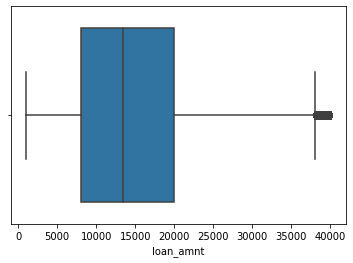

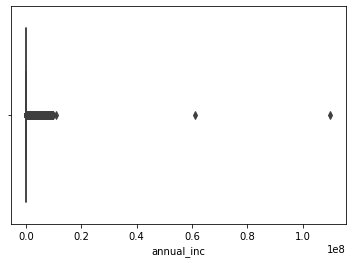

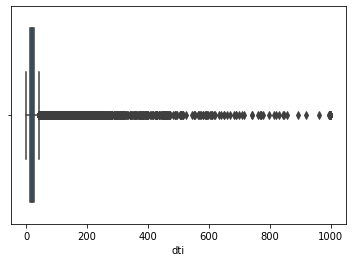

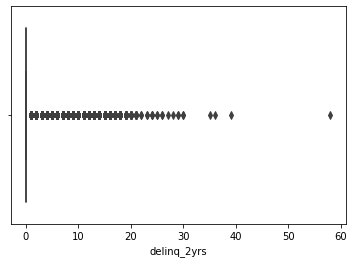

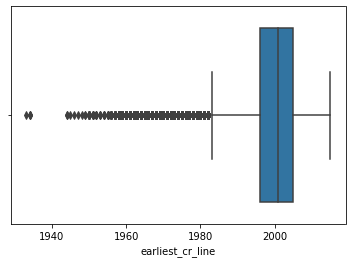

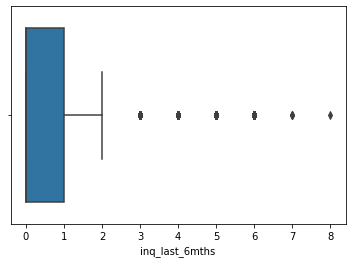

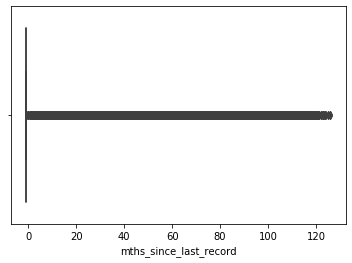

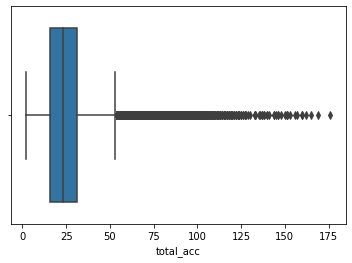

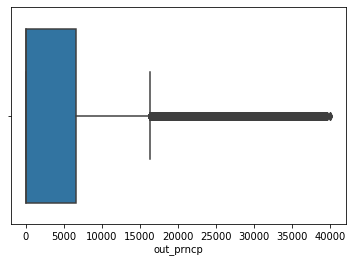

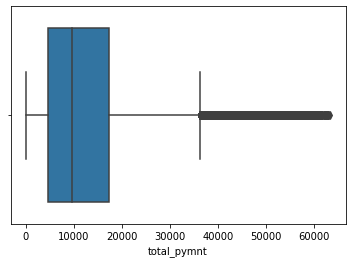

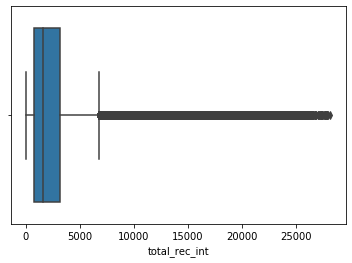

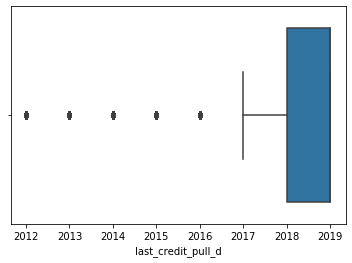

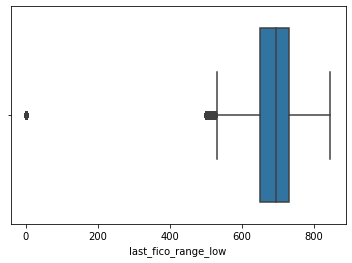

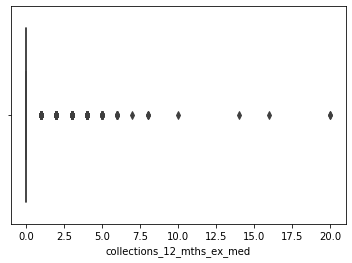

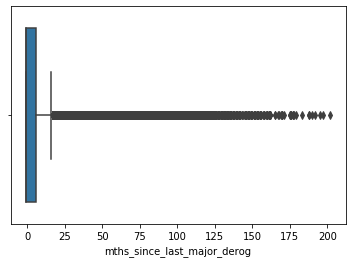

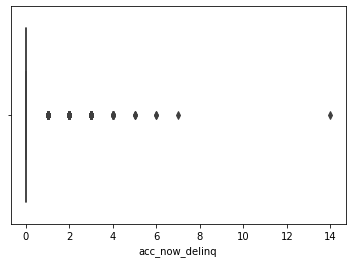

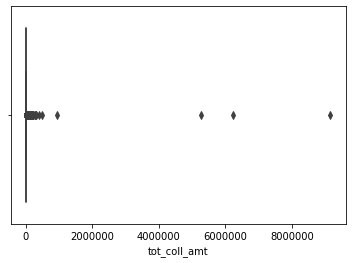

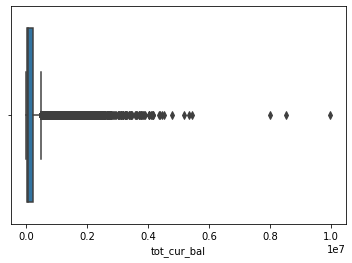

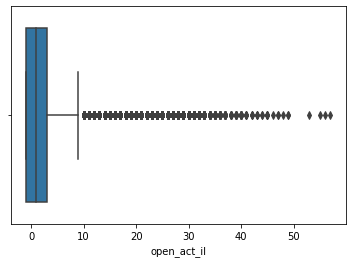

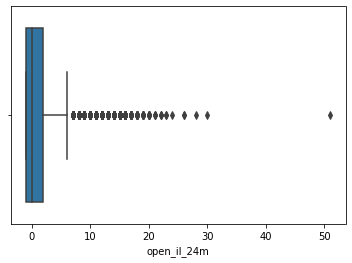

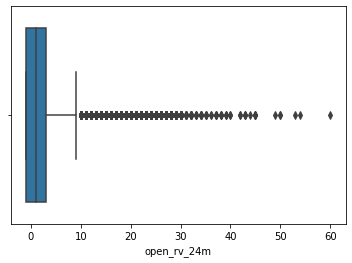

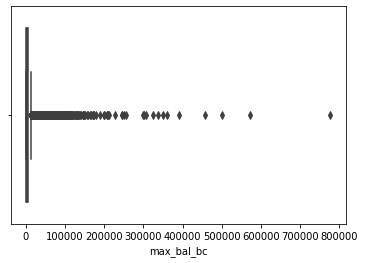

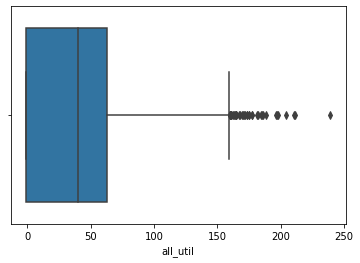

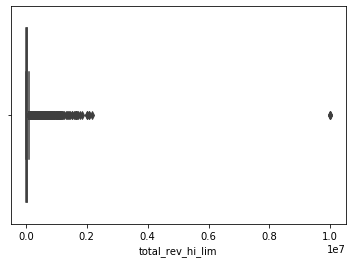

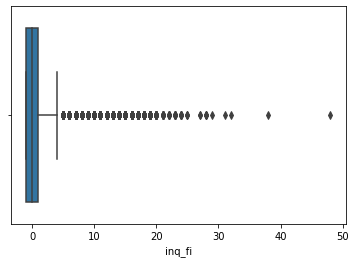

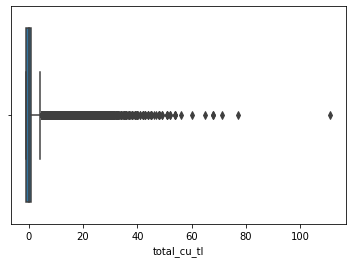

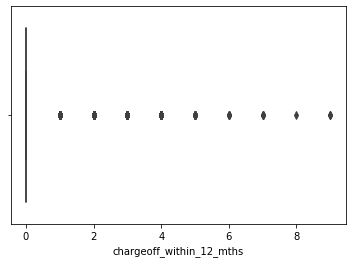

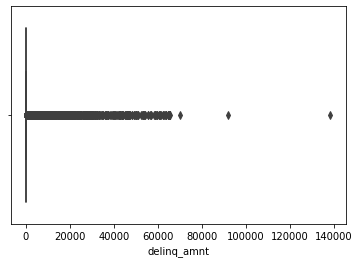

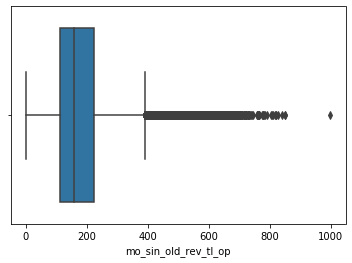

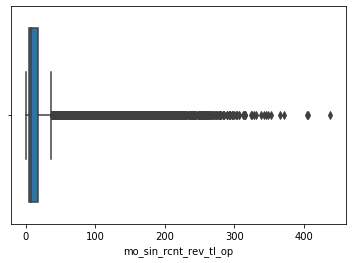

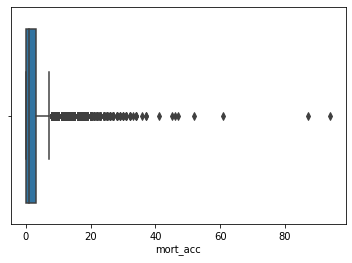

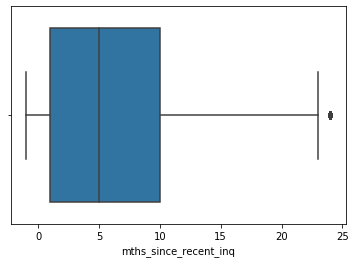

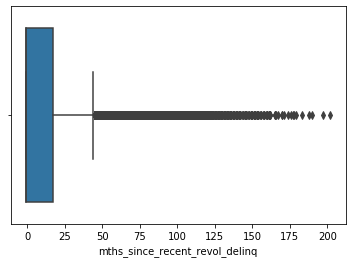

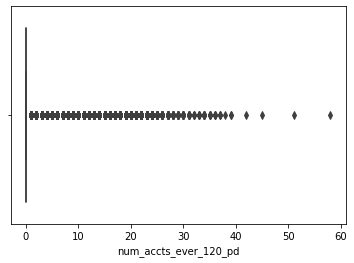

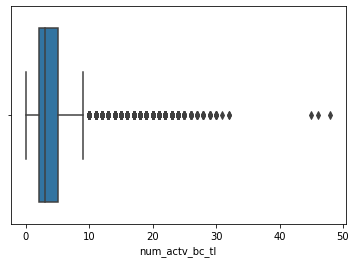

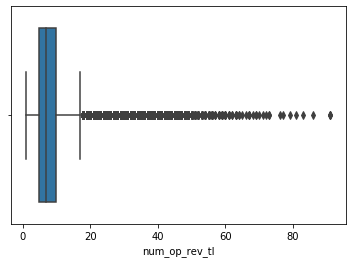

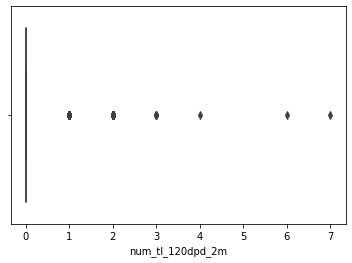

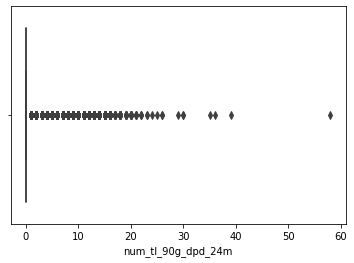

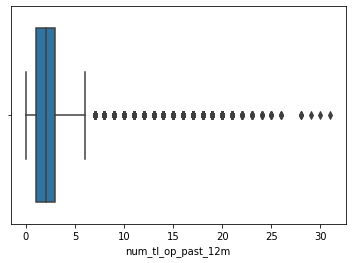

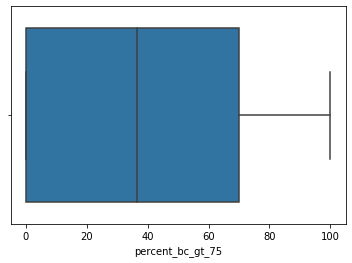

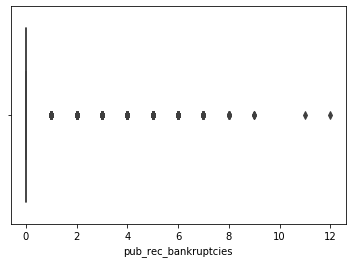

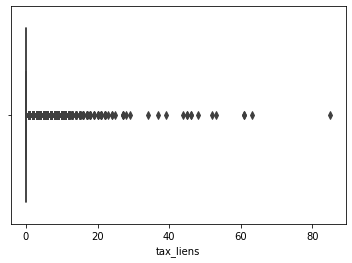

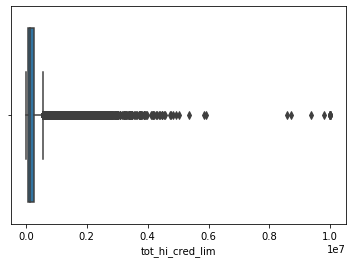

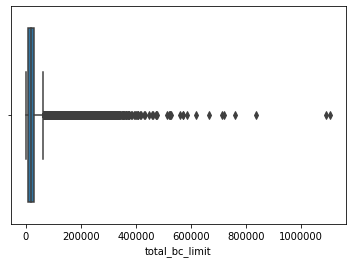

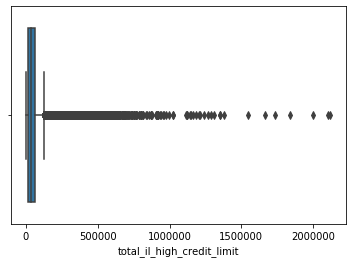

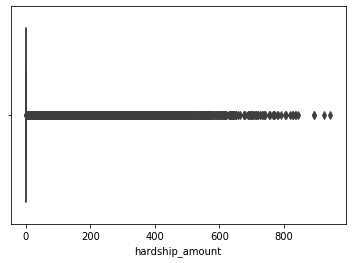

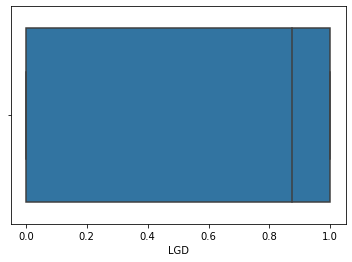

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn
numerical_columns_df = Loan_data.select_dtypes(include=['float64'])
for column in numerical_columns_df.columns:
  if Loan_data[column].isnull().sum() == 0:
    plt.figure()
    sns.boxplot(Loan_data[column])
  else: 
    pass

From the Above distribution graphs, we can see
we need to deal with outliers in 

In [ ]:
## Find number of outliers 
print(Loan_data.loc[(Loan_data['annual_inc'] > 0.5 * 10 ** 8)].count()[0])
print(Loan_data.loc[(Loan_data['annual_inc'] < 0)].count()[0])
## Delete them 
Loan_data = Loan_data.drop(Loan_data[Loan_data['annual_inc'] > 0.5 * 10 ** 8].index, axis = 0)

2
0


In [ ]:
## Find number of outliers 
print(Loan_data.loc[Loan_data['dti'] > 700].count()[0])
print(Loan_data.loc[Loan_data['dti'] < 0].count()[0])

Loan_data = Loan_data.drop(Loan_data[Loan_data['dti'] < 0].index, axis = 0)
Loan_data = Loan_data.drop(Loan_data[Loan_data['dti'] > 700].index, axis = 0)

74
2


In [ ]:
print(Loan_data.loc[Loan_data['delinq_2yrs'] > 30].count()[0])
Loan_data = Loan_data.drop(Loan_data[Loan_data['delinq_2yrs'] > 30].index, axis = 0)

4


In [ ]:
print(Loan_data.loc[Loan_data['total_acc'] > 160].count()[0])
Loan_data = Loan_data.drop(Loan_data[Loan_data['total_acc'] > 30].index, axis = 0)

4


In [ ]:
print(Loan_data.loc[Loan_data['inq_last_6mths'] > 7].count()[0])
#Loan_data = Loan_data.drop(Loan_data[Loan_data['delinq_2yrs'] > 8].index, axis = 0)

1


In [ ]:
print(Loan_data.loc[Loan_data['total_rev_hi_lim'] > 0.8*10**7].count()[0])
Loan_data = Loan_data.drop(Loan_data[Loan_data['total_rev_hi_lim'] > 0.8*10**7\
                                     ].index, axis = 0)

2


In [ ]:
print(Loan_data.loc[Loan_data['last_fico_range_low'] < 200].count()[0] )
## We drop the extreme cases where fico is 0, that is the group where 
## people haven't created any credit record with FICO, so that 
## would be extrme cases, those doesn't belongs to majority of the group 

Loan_data = Loan_data.drop(Loan_data[Loan_data['last_fico_range_low'] < 200].index, axis = 0)

26842


In [ ]:
print(Loan_data.loc[Loan_data['acc_now_delinq'] > 13].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['acc_now_delinq'] > 13].index, axis = 0)

0


In [ ]:
print(Loan_data.loc[Loan_data['tot_coll_amt'] > 4000000].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['tot_coll_amt'] > 4000000].index, axis = 0)

1


In [ ]:
print(Loan_data.loc[Loan_data['total_bc_limit'] > 1000000].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['total_bc_limit'] > 1000000].index, axis = 0)

1


In [ ]:
print(Loan_data.loc[Loan_data['tax_liens'] > 40].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['tax_liens'] > 40].index, axis = 0)

9


In [ ]:
print(Loan_data.loc[Loan_data['mort_acc'] > 50].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['mort_acc'] > 50].index, axis = 0)

0


In [ ]:
print(Loan_data.loc[Loan_data['num_tl_90g_dpd_24m'] > 28].count()[0] )

0


In [ ]:
print(Loan_data.loc[Loan_data['tot_hi_cred_lim'] > 0.6 * 10 ** 7].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['tot_hi_cred_lim'] > 0.6 \
                                     * 10 ** 7].index, axis = 0)

5


In [ ]:
print(Loan_data.loc[Loan_data['total_bc_limit'] > 500000].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['total_bc_limit'] > 500000\
                                     ].index, axis = 0)

3


In [ ]:
print(Loan_data.loc[Loan_data['total_il_high_credit_limit'] > 1000000].count()[0] )
Loan_data = Loan_data.drop(Loan_data[Loan_data['total_il_high_credit_limit'] > \
                                     1000000].index, axis = 0)

7


In [ ]:
Loan_data.shape

(1405627, 56)

## Now we finished clean, and we can create a copy of data to feed in LGD model 

In [ ]:
LGD_Variables = ['hardship_amount','loan_amnt','term','emp_length','home_ownership',
 'annual_inc','zip_code','delinq_2yrs','earliest_cr_line','mths_since_last_record',
 'out_prncp','total_rec_int','total_pymnt','last_fico_range_low',
 'collections_12_mths_ex_med','mths_since_last_major_derog',
 'application_type','acc_now_delinq','tot_coll_amt',
 'chargeoff_within_12_mths','delinq_amnt','mort_acc',
 'mths_since_recent_revol_delinq','num_accts_ever_120_pd',
 'num_tl_120dpd_2m','num_tl_90g_dpd_24m','percent_bc_gt_75',
 'pub_rec_bankruptcies', 'tax_liens',
 'total_bc_limit','sec_app_chargeoff_within_12_mths',
 'debt_settlement_flag','LGD', 'loan_status']

In [ ]:

LGD_data = Loan_data.loc[Loan_data['loan_status'] != 0]

In [ ]:
Loan_data.to_csv("credit_data.csv", index=False)
LGD_data.to_csv('LGD_data.csv',index = False)
!ls

'Coursework 2 - Lending Club Data.zip'	 sample_data
 credit_data.csv			 test_woe.csv
 LCFinal.csv				 train_woe.csv
 LGD_data.csv				'Variable Dictionary.docx'


In [ ]:
from google.colab import files


In [ ]:
%%script false
files.download('credit_data.csv')
files.download('LGD_data.csv')

MessageError: ignored

# Part II Construct ScoreCard


## Convert Variables to WOE Values

In [ ]:
!pip install scorecardpy
import scorecardpy as sc
import numpy as np

In [ ]:
Loan_data.head(1)

,loan_amnt,term,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_record,total_acc,out_prncp,total_pymnt,total_rec_int,last_credit_pull_d,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,open_il_24m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_op_rev_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_amount,debt_settlement_flag,LGD
0,3600.0,36 months,10,MORTGAGE,55000.0,0,debt_consolidation,1,5.91,0.0,2003.0,1.0,-1.0,13.0,0.0,4421.723917,821.72,2019.0,560.0,0.0,30.0,Individual,0.0,722.0,144904.0,2.0,1.0,3.0,722.0,34.0,9300.0,3.0,1.0,0.0,0.0,128.0,3.0,1.0,4.0,69.0,2.0,2.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,178050.0,2400.0,13734.0,N,0.0,N,0.0


In [ ]:
# Split in train and test BEFORE we apply WoE
train, test = sc.split_df(Loan_data.iloc[:,:-1],
                          y = 'loan_status',
                          ratio = 0.66, seed = 251121253).values()

In [ ]:
train.describe()

,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_record,total_acc,out_prncp,total_pymnt,total_rec_int,last_credit_pull_d,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,open_il_24m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_op_rev_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,hardship_amount
count,927713.000000,927713.000000,9.277130e+05,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,9.277130e+05,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,9.277130e+05,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,927713.000000,9.277130e+05,927713.000000,927713.000000,927713.000000
mean,14623.961559,5.800675,7.432955e+04,17.752148,0.265741,2000.822932,0.473378,10.526609,18.725004,4440.051839,11563.375957,2342.903322,2018.480197,687.347693,0.017075,9.803013,0.003447,205.569403,1.221721e+05,1.166420,0.522417,1.181668,3631.251179,36.595357,2.950474e+04,0.254200,0.383784,0.006166,9.094775,165.716129,15.439982,1.229459,6.367142,10.318800,0.422499,3.350232,7.031097,0.000520,0.063593,1.778645,42.996655,0.120183,0.051176,1.533256e+05,20623.255690,36011.916856,0.668596
std,8971.560421,3.720349,6.959218e+04,10.529291,0.748318,7.429960,0.773623,29.101855,6.638534,7370.515599,9515.251949,2580.948897,0.946408,69.185637,0.142485,22.115650,0.061903,2006.620204,1.440997e+05,2.431242,1.563088,2.392293,4996.470003,32.221462,2.789601e+04,1.454177,1.900223,0.083581,590.360720,90.925495,18.667166,1.603452,6.395820,20.988355,1.097066,1.920374,3.395179,0.024254,0.380398,1.587047,36.835549,0.356579,0.376537,1.598689e+05,19015.661616,34501.287665,13.121268
min,1000.000000,0.000000,0.000000e+00,0.000000,0.000000,1934.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,0.000000,2012.000000,500.000000,0.000000,-1.000000,0.000000,0.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000e+02,-1.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,100.000000,0.000000,0.000000
25%,8000.000000,2.000000,4.500000e+04,11.050000,0.000000,1997.000000,0.000000,-1.000000,14.000000,0.000000,4356.100000,712.000000,2018.000000,655.000000,0.000000,-1.000000,0.000000,0.000000,2.527600e+04,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.350000e+04,-1.000000,-1.000000,0.000000,0.000000,103.000000,4.000000,0.000000,1.000000,-1.000000,0.000000,2.000000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.468100e+04,7900.000000,13068.000000,0.000000
50%,12000.000000,6.000000,6.300000e+04,16.770000,0.000000,2002.000000,0.000000,-1.000000,19.000000,0.000000,8943.120000,1478.550000,2019.000000,695.000000,0.000000,-1.000000,0.000000,0.000000,5.813200e+04,1.000000,0.000000,1.000000,2052.000000,42.000000,2.270000e+04,0.000000,0.000000,0.000000,0.000000,149.000000,9.000000,1.000000,5.000000,-1.000000,0.000000,3.000000,7.000000,0.000000,0.000000,1.000000,40.000000,0.000000,0.000000,8.880100e+04,15000.000000,28703.000000,0.000000
75%,20000.000000,10.000000,8.950000e+04,23.340000,0.000000,2006.000000,1.000000,-1.000000,24.000000,6827.100000,16214.480000,2979.310000,2019.000000,730.000000,0.000000,-1.000000,0.000000,0.000000,

In [ ]:
bins = sc.woebin(train, y = 'loan_status', 
                 min_perc_fine_bin=0.05, 
                 min_perc_coarse_bin=0.05,  
                 stop_limit=0.1,  
                 max_num_bin=8, 
                 method='tree')

[INFO] creating woe binning ...
Binning on 927713 rows and 55 columns in 00:02:58


/usr/local/lib/python3.6/dist-packages/scorecardpy/woebin.py:1197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


{'acc_now_delinq': <Figure size 432x288 with 2 Axes>,
 'all_util': <Figure size 432x288 with 2 Axes>,
 'annual_inc': <Figure size 432x288 with 2 Axes>,
 'application_type': <Figure size 432x288 with 2 Axes>,
 'chargeoff_within_12_mths': <Figure size 432x288 with 2 Axes>,
 'collections_12_mths_ex_med': <Figure size 432x288 with 2 Axes>,
 'debt_settlement_flag': <Figure size 432x288 with 2 Axes>,
 'delinq_2yrs': <Figure size 432x288 with 2 Axes>,
 'delinq_amnt': <Figure size 432x288 with 2 Axes>,
 'dti': <Figure size 432x288 with 2 Axes>,
 'earliest_cr_line': <Figure size 432x288 with 2 Axes>,
 'emp_length': <Figure size 432x288 with 2 Axes>,
 'hardship_amount': <Figure size 432x288 with 2 Axes>,
 'hardship_flag': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>,
 'inq_fi': <Figure size 432x288 with 2 Axes>,
 'inq_last_6mths': <Figure size 432x288 with 2 Axes>,
 'last_credit_pull_d': <Figure size 432x288 with 2 Axes>,
 'last_fico_range_low': <Figure

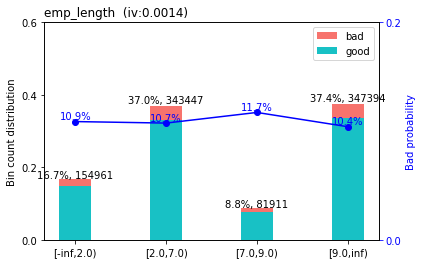

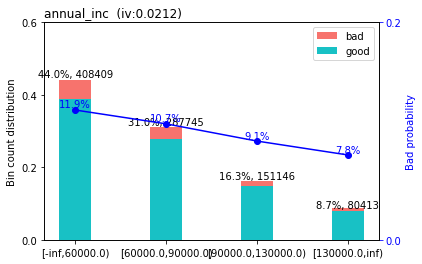

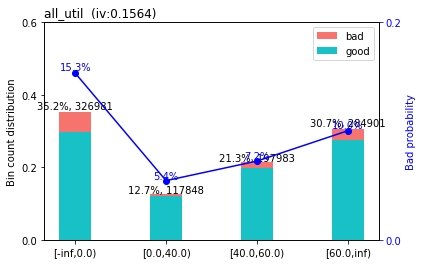

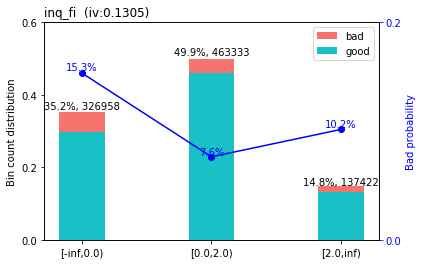

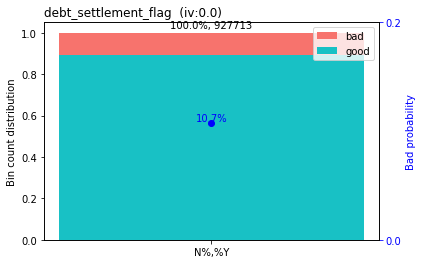

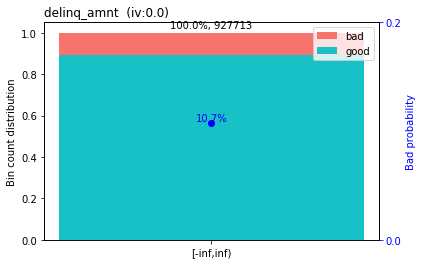

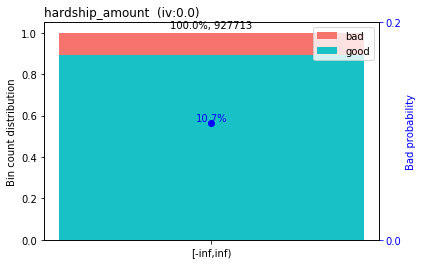

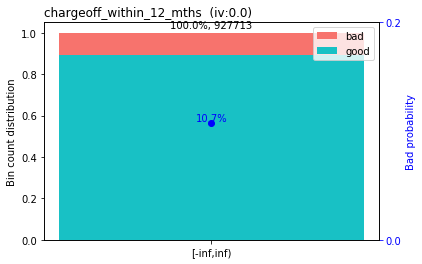

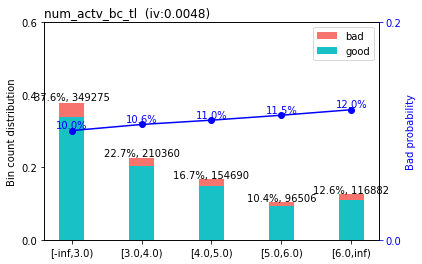

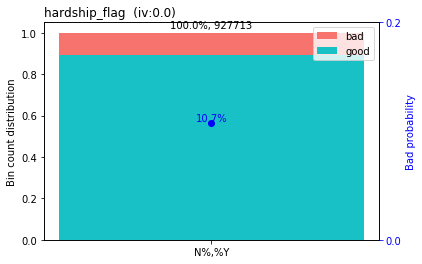

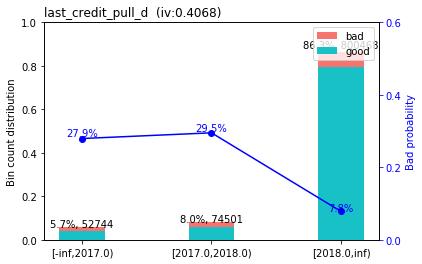

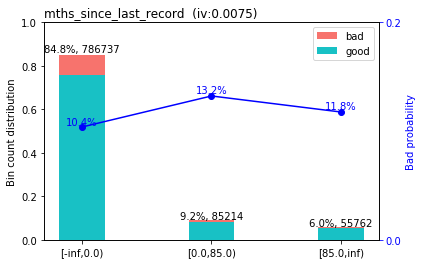

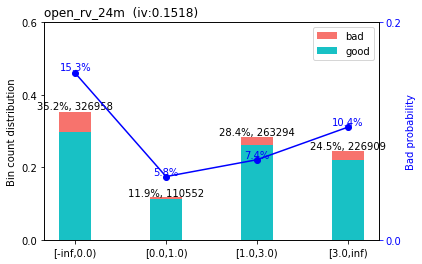

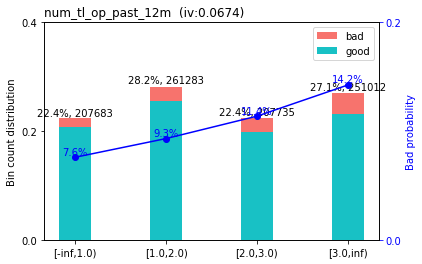

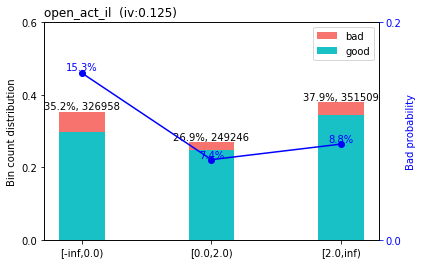

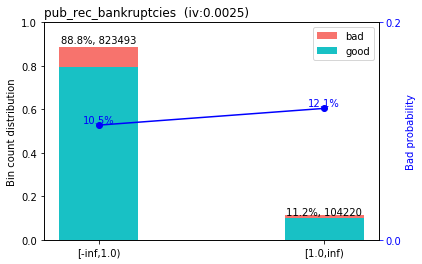

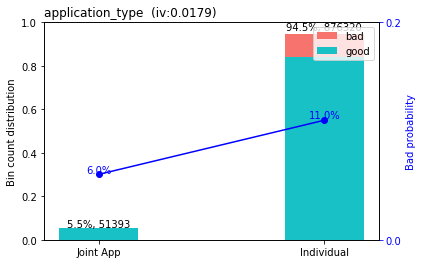

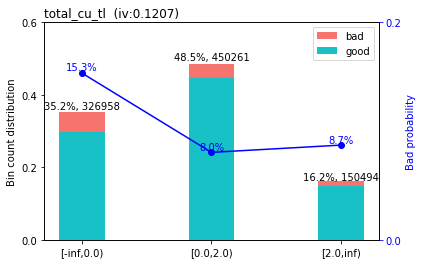

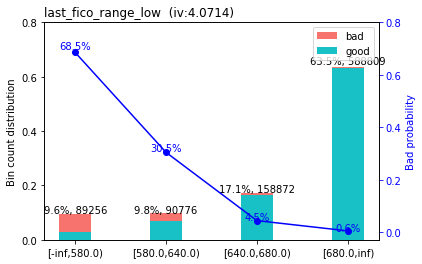

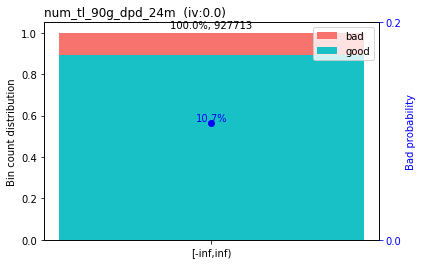

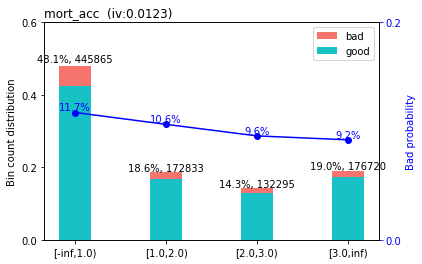

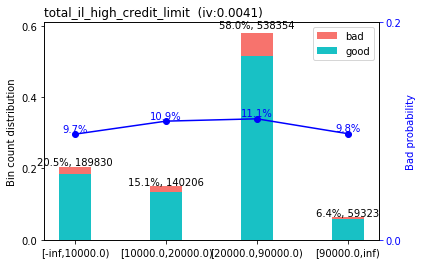

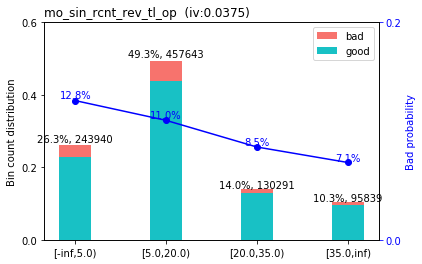

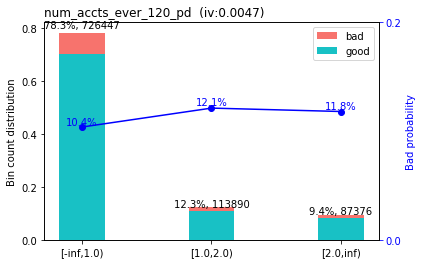

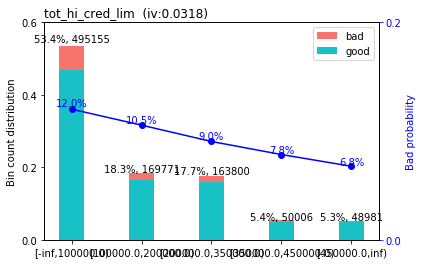

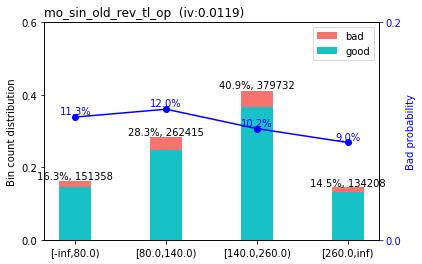

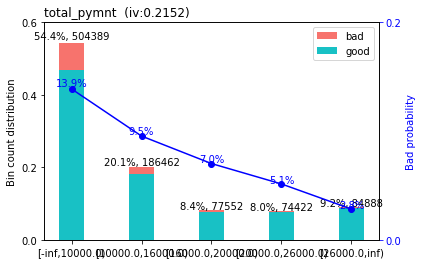

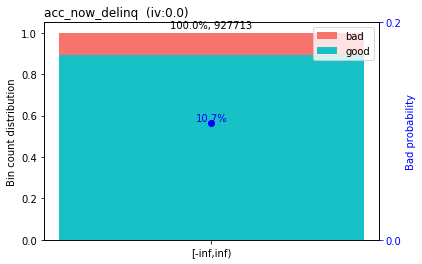

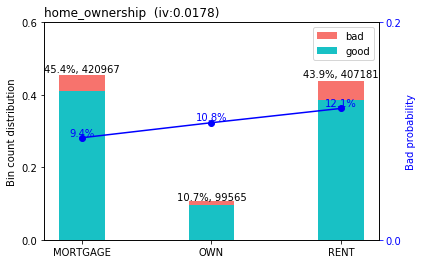

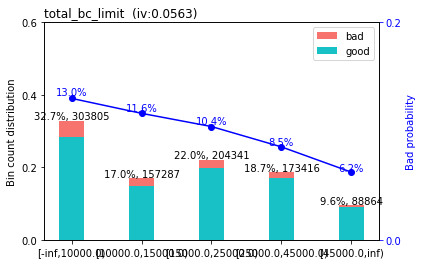

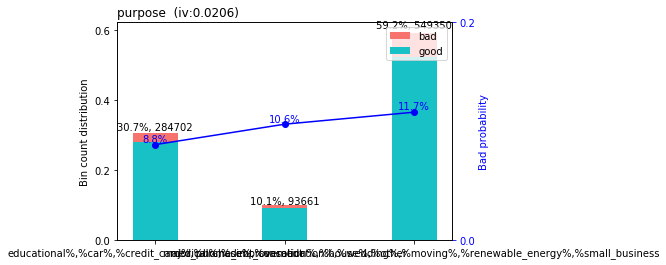

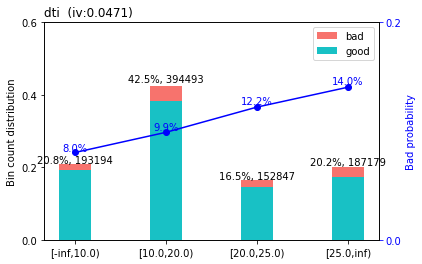

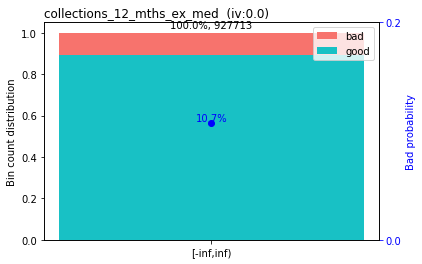

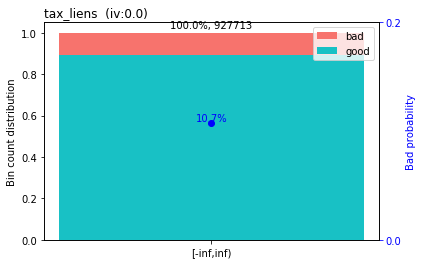

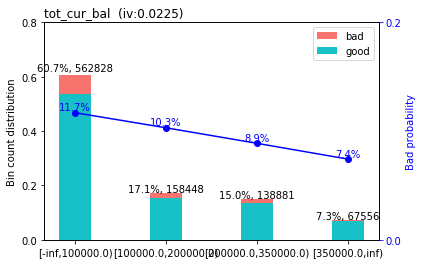

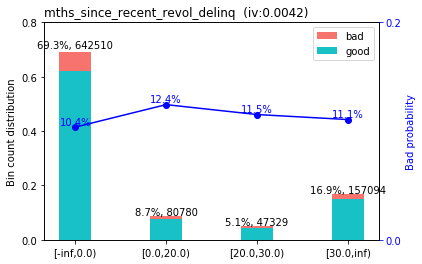

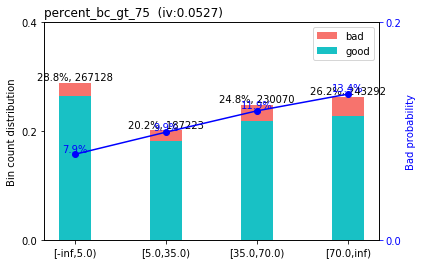

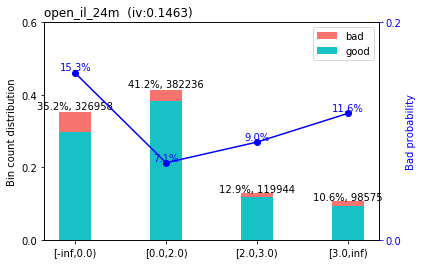

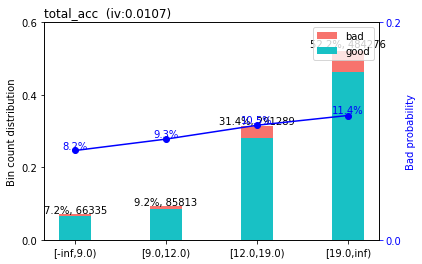

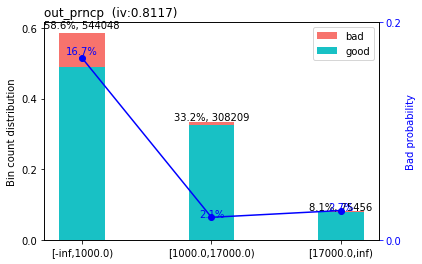

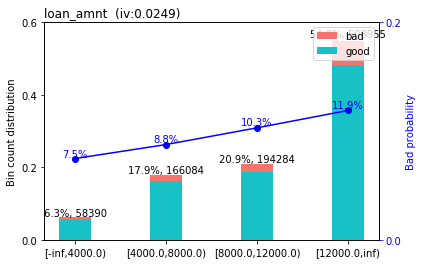

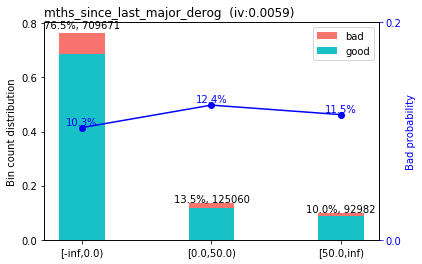

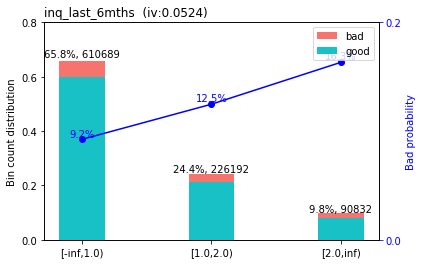

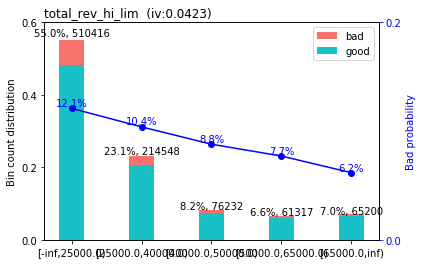

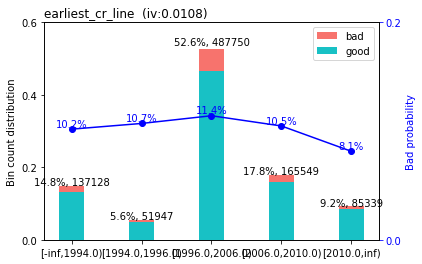

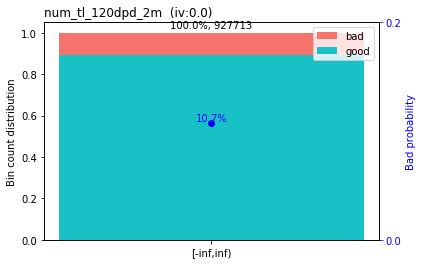

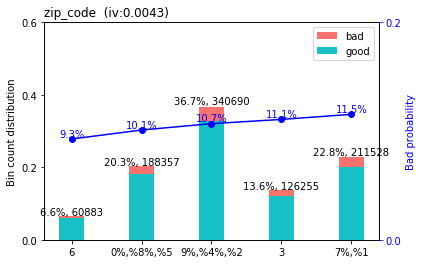

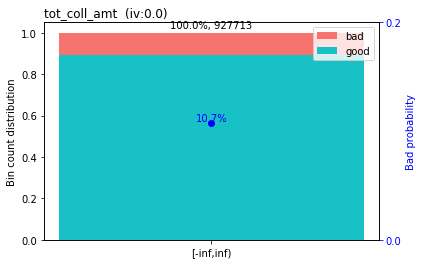

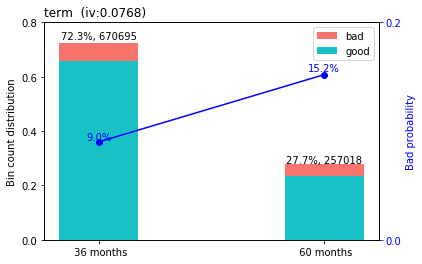

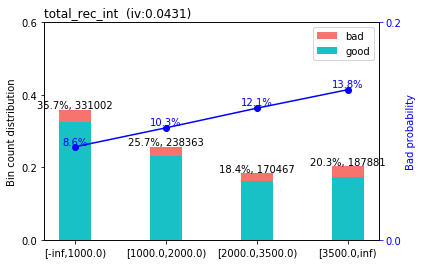

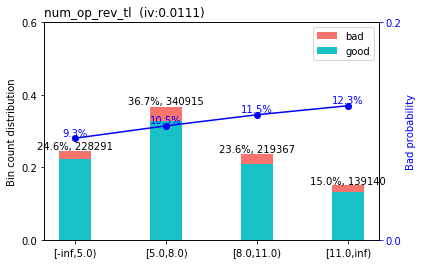

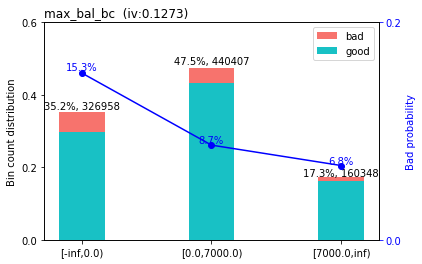

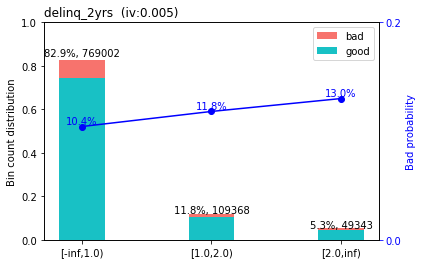

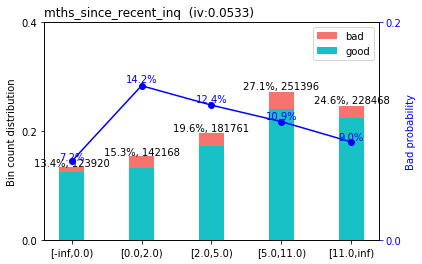

In [ ]:
sc.woebin_plot(bins)

-------- 1/28 annual_inc --------
>>> dt[annual_inc].describe(): 
count    9.277130e+05
mean     7.432955e+04
std      6.959218e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.300000e+04
75%      8.950000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64 



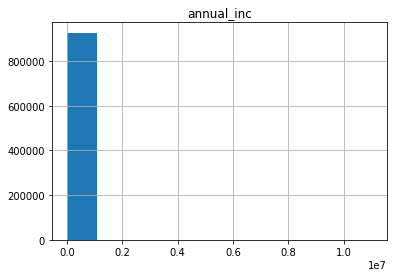

>>> Current breaks:
60000.0,90000.0,130000.0 



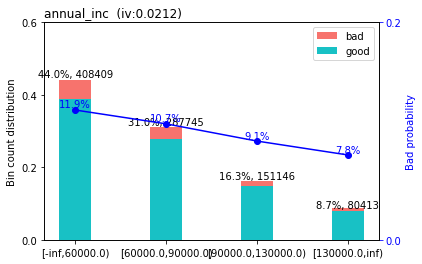

>>> Adjust breaks for (1/28) annual_inc?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/28 earliest_cr_line --------
>>> dt[earliest_cr_line].describe(): 
count    927713.000000
mean       2000.822932
std           7.429960
min        1934.000000
25%        1997.000000
50%        2002.000000
75%        2006.000000
max        2015.000000
Name: earliest_cr_line, dtype: float64 



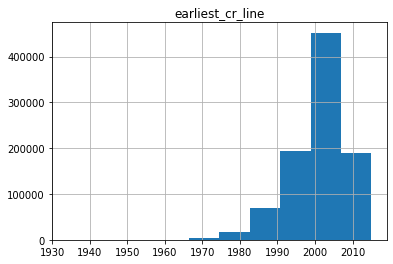

>>> Current breaks:
1994.0,1996.0,2006.0,2010.0 



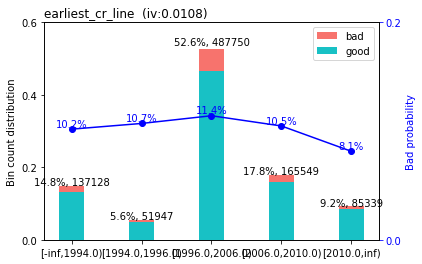

>>> Adjust breaks for (2/28) earliest_cr_line?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/28 emp_length --------
>>> dt[emp_length].describe(): 
count    927713.000000
mean          5.800675
std           3.720349
min           0.000000
25%           2.000000
50%           6.000000
75%          10.000000
max          10.000000
Name: emp_length, dtype: float64 



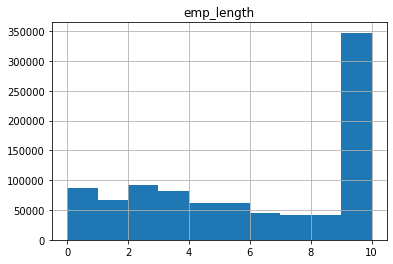

>>> Current breaks:
2.0,7.0,9.0 



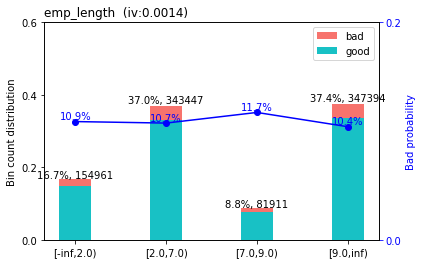

>>> Adjust breaks for (3/28) emp_length?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/28 last_fico_range_low --------
>>> dt[last_fico_range_low].describe(): 
count    927713.000000
mean        687.347693
std          69.185637
min         500.000000
25%         655.000000
50%         695.000000
75%         730.000000
max         845.000000
Name: last_fico_range_low, dtype: float64 



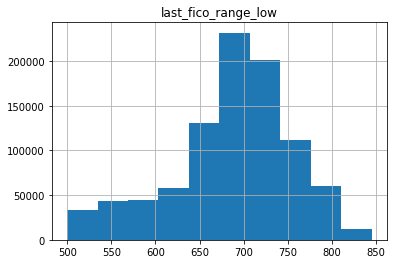

>>> Current breaks:
580.0,640.0,680.0 



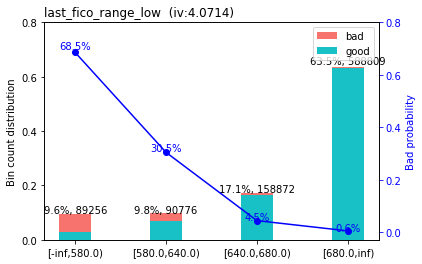

>>> Adjust breaks for (4/28) last_fico_range_low?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/28 max_bal_bc --------
>>> dt[max_bal_bc].describe(): 
count    927713.000000
mean       3631.251179
std        4996.470003
min          -1.000000
25%          -1.000000
50%        2052.000000
75%        5351.000000
max      325000.000000
Name: max_bal_bc, dtype: float64 



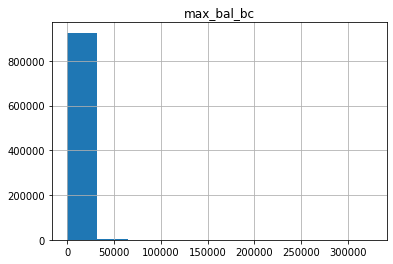

>>> Current breaks:
0.0,7000.0 



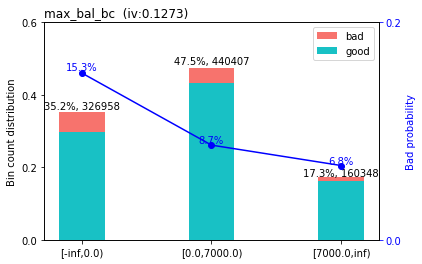

>>> Adjust breaks for (5/28) max_bal_bc?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/28 mo_sin_old_rev_tl_op --------
>>> dt[mo_sin_old_rev_tl_op].describe(): 
count    927713.000000
mean        165.716129
std          90.925495
min           1.000000
25%         103.000000
50%         149.000000
75%         213.000000
max         999.000000
Name: mo_sin_old_rev_tl_op, dtype: float64 



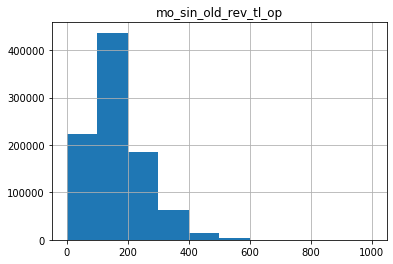

>>> Current breaks:
80.0,140.0,260.0 



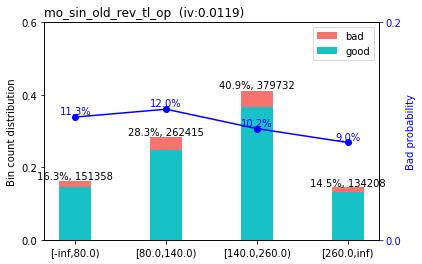

>>> Adjust breaks for (6/28) mo_sin_old_rev_tl_op?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/28 mo_sin_rcnt_rev_tl_op --------
>>> dt[mo_sin_rcnt_rev_tl_op].describe(): 
count    927713.000000
mean         15.439982
std          18.667166
min           0.000000
25%           4.000000
50%           9.000000
75%          19.000000
max         438.000000
Name: mo_sin_rcnt_rev_tl_op, dtype: float64 



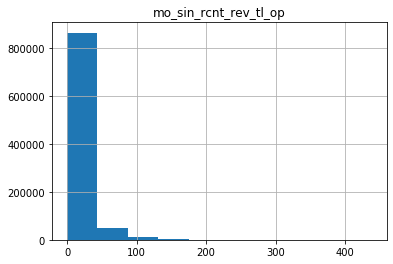

>>> Current breaks:
5.0,20.0,35.0 



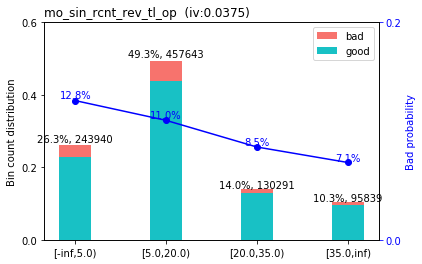

>>> Adjust breaks for (7/28) mo_sin_rcnt_rev_tl_op?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/28 mort_acc --------
>>> dt[mort_acc].describe(): 
count    927713.000000
mean          1.229459
std           1.603452
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          20.000000
Name: mort_acc, dtype: float64 



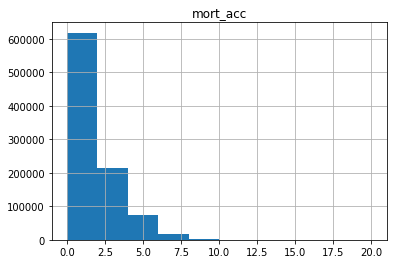

>>> Current breaks:
1.0,2.0,3.0 



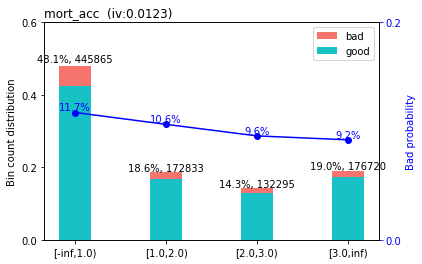

>>> Adjust breaks for (8/28) mort_acc?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/28 mths_since_last_record --------
>>> dt[mths_since_last_record].describe(): 
count    927713.000000
mean         10.526609
std          29.101855
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max         126.000000
Name: mths_since_last_record, dtype: float64 



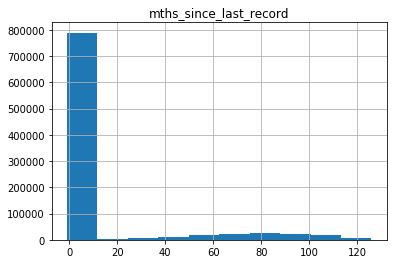

>>> Current breaks:
0.0,85.0 



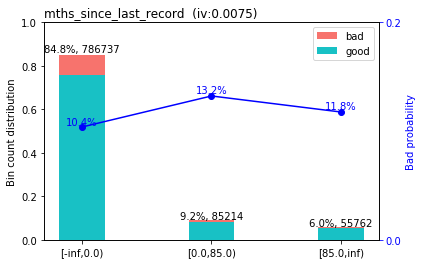

>>> Adjust breaks for (9/28) mths_since_last_record?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/28 mths_since_recent_inq --------
>>> dt[mths_since_recent_inq].describe(): 
count    927713.000000
mean          6.367142
std           6.395820
min          -1.000000
25%           1.000000
50%           5.000000
75%          10.000000
max          24.000000
Name: mths_since_recent_inq, dtype: float64 



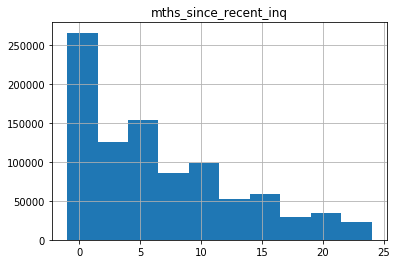

>>> Current breaks:
0.0,2.0,5.0,11.0 



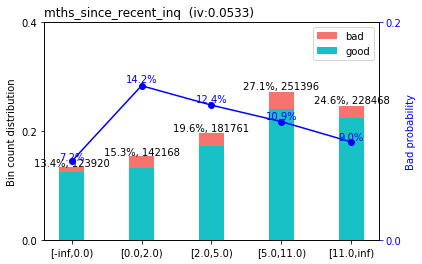

>>> Adjust breaks for (10/28) mths_since_recent_inq?
1: next 
2: yes 
3: back
Selection: 1
-------- 11/28 mths_since_recent_revol_delinq --------
>>> dt[mths_since_recent_revol_delinq].describe(): 
count    927713.000000
mean         10.318800
std          20.988355
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          14.000000
max         202.000000
Name: mths_since_recent_revol_delinq, dtype: float64 



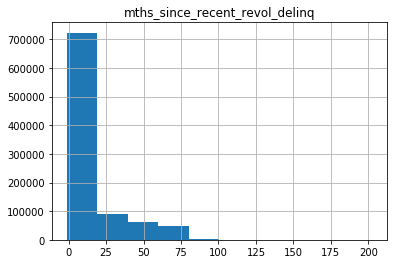

>>> Current breaks:
0.0,20.0,30.0 



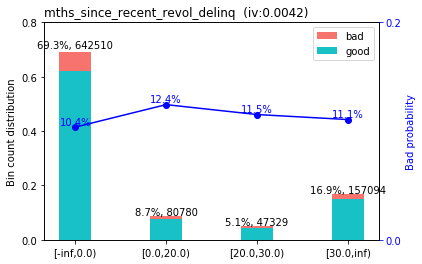

>>> Adjust breaks for (11/28) mths_since_recent_revol_delinq?
1: next 
2: yes 
3: back
Selection: 1
-------- 12/28 num_accts_ever_120_pd --------
>>> dt[num_accts_ever_120_pd].describe(): 
count    927713.000000
mean          0.422499
std           1.097066
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: num_accts_ever_120_pd, dtype: float64 



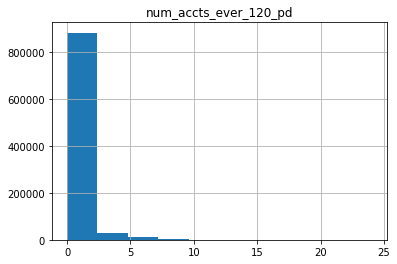

>>> Current breaks:
1.0,2.0 



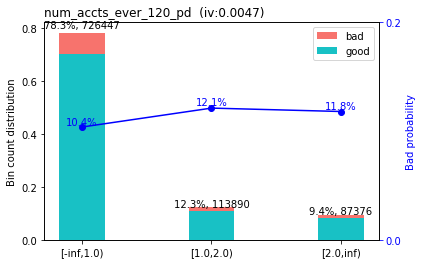

>>> Adjust breaks for (12/28) num_accts_ever_120_pd?
1: next 
2: yes 
3: back
Selection: 1
-------- 13/28 num_actv_bc_tl --------
>>> dt[num_actv_bc_tl].describe(): 
count    927713.000000
mean          3.350232
std           1.920374
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          21.000000
Name: num_actv_bc_tl, dtype: float64 



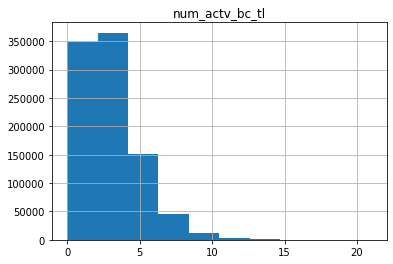

>>> Current breaks:
3.0,4.0,5.0,6.0 



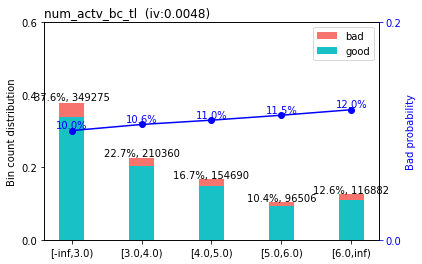

>>> Adjust breaks for (13/28) num_actv_bc_tl?
1: next 
2: yes 
3: back
Selection: 1
-------- 14/28 num_tl_op_past_12m --------
>>> dt[num_tl_op_past_12m].describe(): 
count    927713.000000
mean          1.778645
std           1.587047
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          22.000000
Name: num_tl_op_past_12m, dtype: float64 



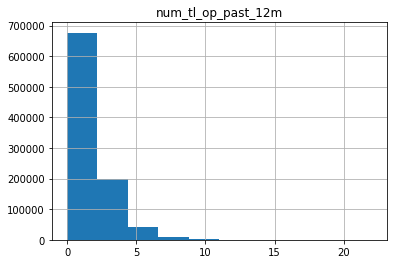

>>> Current breaks:
1.0,2.0,3.0 



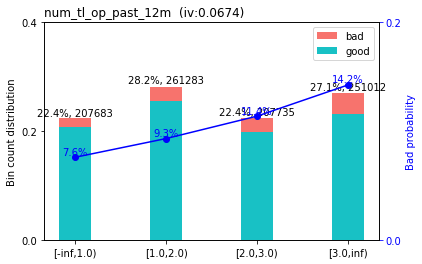

>>> Adjust breaks for (14/28) num_tl_op_past_12m?
1: next 
2: yes 
3: back
Selection: 1
-------- 15/28 open_il_24m --------
>>> dt[open_il_24m].describe(): 
count    927713.000000
mean          0.522417
std           1.563088
min          -1.000000
25%          -1.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: open_il_24m, dtype: float64 



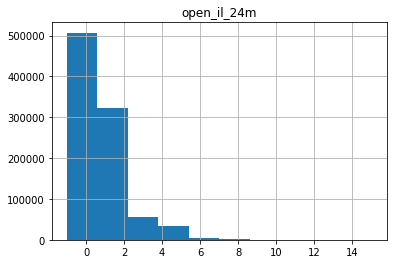

>>> Current breaks:
0.0,2.0,3.0 



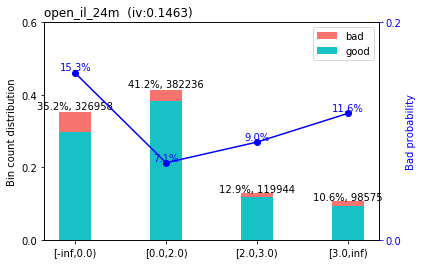

>>> Adjust breaks for (15/28) open_il_24m?
1: next 
2: yes 
3: back
Selection: 1
-------- 16/28 percent_bc_gt_75 --------
>>> dt[percent_bc_gt_75].describe(): 
count    927713.000000
mean         42.996655
std          36.835549
min           0.000000
25%           0.000000
50%          40.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64 



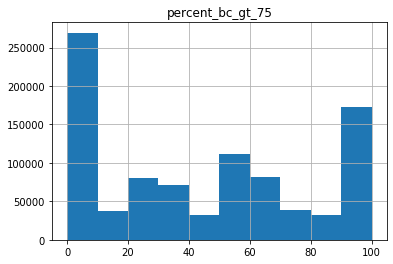

>>> Current breaks:
5.0,35.0,70.0 



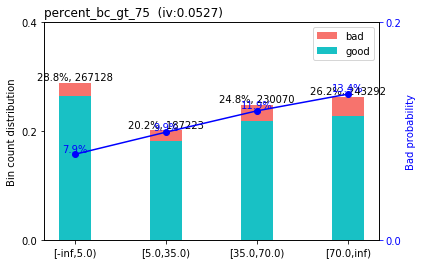

>>> Adjust breaks for (16/28) percent_bc_gt_75?
1: next 
2: yes 
3: back
Selection: 1
-------- 17/28 purpose --------
>>> dt[purpose].describe(): 
count                 927713
unique                    14
top       debt_consolidation
freq                  520472
Name: purpose, dtype: object 

>>> dt[purpose].value_counts(): 
debt_consolidation    520472
credit_card           216164
other                  59490
home_improvement       58234
major_purchase         21763
medical                11140
car                    10303
small_business         10095
moving                  6596
vacation                6420
house                   5988
renewable_energy         583
wedding                  464
educational                1
Name: purpose, dtype: int64 

>>> Current breaks:
'educational%,%car%,%credit_card%,%home_improvement','major_purchase%,%vacation%,%house%,%other','medical%,%debt_consolidation%,%wedding%,%moving%,%renewable_energy%,%small_business' 



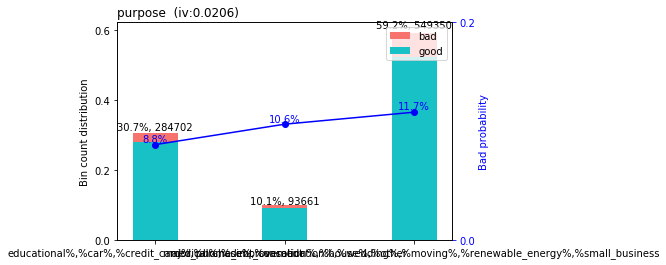

>>> Adjust breaks for (17/28) purpose?
1: next 
2: yes 
3: back
Selection: 1
-------- 18/28 term --------
>>> dt[term].describe(): 
count         927713
unique             2
top        36 months
freq          670695
Name: term, dtype: object 

>>> dt[term].value_counts(): 
 36 months    670695
 60 months    257018
Name: term, dtype: int64 

>>> Current breaks:
' 36 months',' 60 months' 



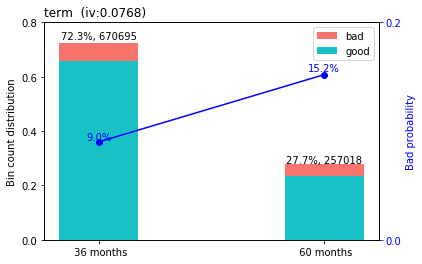

>>> Adjust breaks for (18/28) term?
1: next 
2: yes 
3: back
Selection: 1
-------- 19/28 tot_cur_bal --------
>>> dt[tot_cur_bal].describe(): 
count    9.277130e+05
mean     1.221721e+05
std      1.440997e+05
min      0.000000e+00
25%      2.527600e+04
50%      5.813200e+04
75%      1.828060e+05
max      4.772549e+06
Name: tot_cur_bal, dtype: float64 



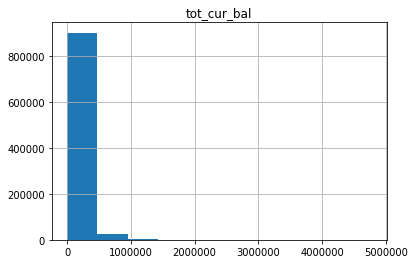

>>> Current breaks:
100000.0,200000.0,350000.0 



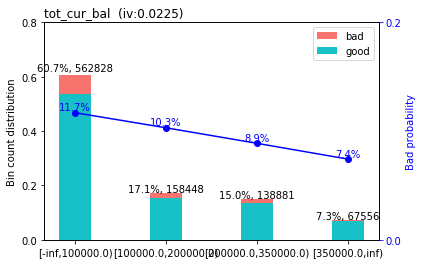

>>> Adjust breaks for (19/28) tot_cur_bal?
1: next 
2: yes 
3: back
Selection: 1
-------- 20/28 tot_hi_cred_lim --------
>>> dt[tot_hi_cred_lim].describe(): 
count    9.277130e+05
mean     1.533256e+05
std      1.598689e+05
min      1.000000e+02
25%      4.468100e+04
50%      8.880100e+04
75%      2.210810e+05
max      5.022617e+06
Name: tot_hi_cred_lim, dtype: float64 



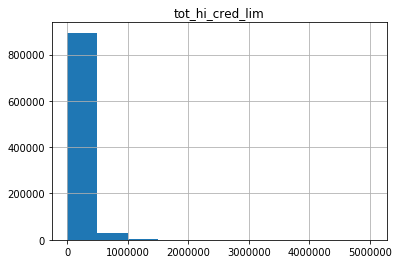

>>> Current breaks:
100000.0,200000.0,350000.0,450000.0 



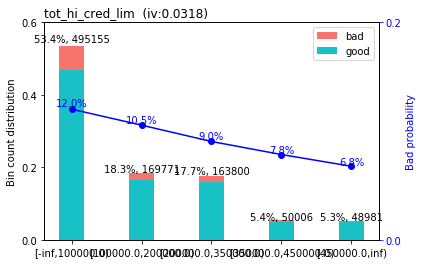

>>> Adjust breaks for (20/28) tot_hi_cred_lim?
1: next 
2: yes 
3: back
Selection: 1
-------- 21/28 total_acc --------
>>> dt[total_acc].describe(): 
count    927713.000000
mean         18.725004
std           6.638534
min           2.000000
25%          14.000000
50%          19.000000
75%          24.000000
max          30.000000
Name: total_acc, dtype: float64 



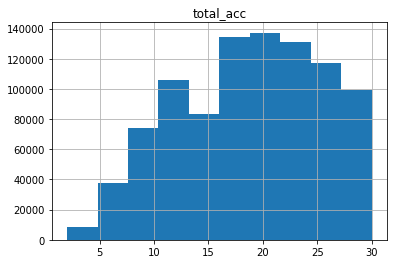

>>> Current breaks:
9.0,12.0,19.0 



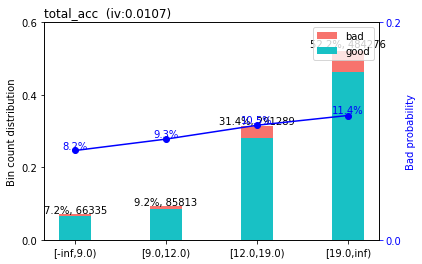

>>> Adjust breaks for (21/28) total_acc?
1: next 
2: yes 
3: back
Selection: 1
-------- 22/28 total_bc_limit --------
>>> dt[total_bc_limit].describe(): 
count    927713.000000
mean      20623.255690
std       19015.661616
min         100.000000
25%        7900.000000
50%       15000.000000
75%       27100.000000
max      431100.000000
Name: total_bc_limit, dtype: float64 



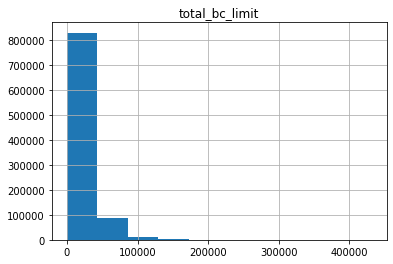

>>> Current breaks:
10000.0,15000.0,25000.0,45000.0 



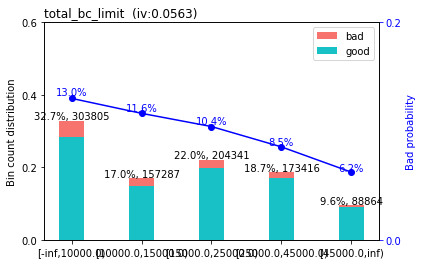

>>> Adjust breaks for (22/28) total_bc_limit?
1: next 
2: yes 
3: back
Selection: 1
-------- 23/28 total_cu_tl --------
>>> dt[total_cu_tl].describe(): 
count    927713.000000
mean          0.383784
std           1.900223
min          -1.000000
25%          -1.000000
50%           0.000000
75%           1.000000
max          24.000000
Name: total_cu_tl, dtype: float64 



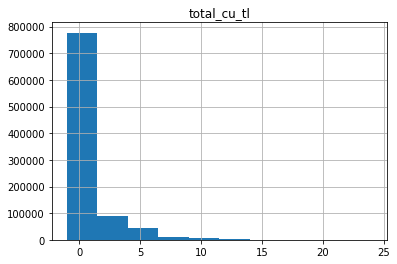

>>> Current breaks:
0.0,2.0 



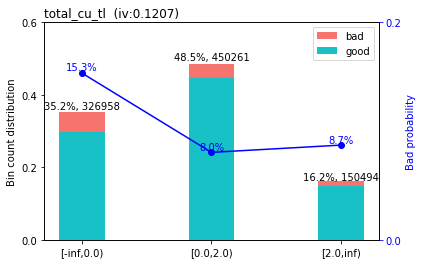

>>> Adjust breaks for (23/28) total_cu_tl?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 0.0,1.0,2.0 
[INFO] creating woe binning ...
>>> Current breaks:
0.0, 1.0, 2.0 



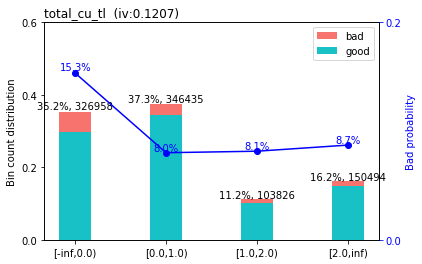

>>> Adjust breaks for (23/28) total_cu_tl?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 0.0, 1.0, 2.0, 3.0
[INFO] creating woe binning ...
>>> Current breaks:
0.0, 1.0, 3.0, 2.0 



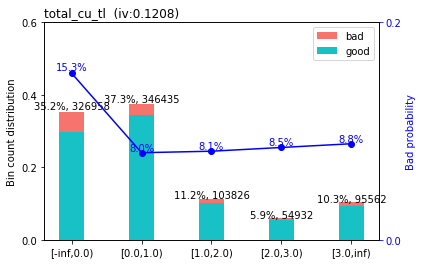

>>> Adjust breaks for (23/28) total_cu_tl?
1: next 
2: yes 
3: back
Selection: 1
-------- 24/28 total_il_high_credit_limit --------
>>> dt[total_il_high_credit_limit].describe(): 
count    927713.000000
mean      36011.916856
std       34501.287665
min           0.000000
25%       13068.000000
50%       28703.000000
75%       49499.000000
max      856554.000000
Name: total_il_high_credit_limit, dtype: float64 



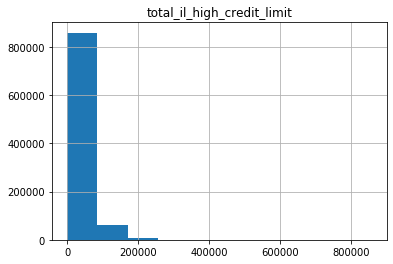

>>> Current breaks:
10000.0,20000.0,90000.0 



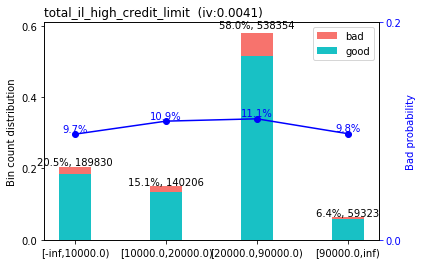

>>> Adjust breaks for (24/28) total_il_high_credit_limit?
1: next 
2: yes 
3: back
Selection: 1
-------- 25/28 total_pymnt --------
>>> dt[total_pymnt].describe(): 
count    927713.000000
mean      11563.375957
std        9515.251949
min           0.000000
25%        4356.100000
50%        8943.120000
75%       16214.480000
max       62837.639685
Name: total_pymnt, dtype: float64 



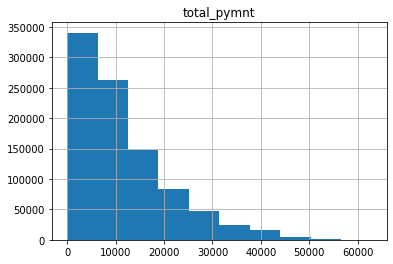

>>> Current breaks:
10000.0,16000.0,20000.0,26000.0 



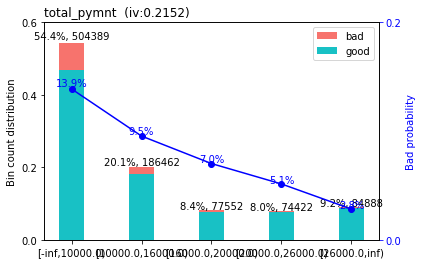

>>> Adjust breaks for (25/28) total_pymnt?
1: next 
2: yes 
3: back
Selection: 1
-------- 26/28 total_rec_int --------
>>> dt[total_rec_int].describe(): 
count    927713.000000
mean       2342.903322
std        2580.948897
min           0.000000
25%         712.000000
50%        1478.550000
75%        2979.310000
max       27922.660000
Name: total_rec_int, dtype: float64 



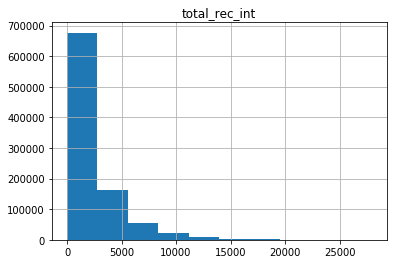

>>> Current breaks:
1000.0,2000.0,3500.0 



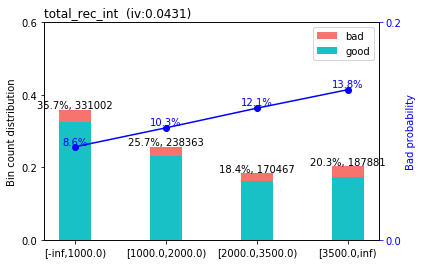

>>> Adjust breaks for (26/28) total_rec_int?
1: next 
2: yes 
3: back
Selection: 1
-------- 27/28 total_rev_hi_lim --------
>>> dt[total_rev_hi_lim].describe(): 
count    9.277130e+05
mean     2.950474e+04
std      2.789601e+04
min      1.000000e+02
25%      1.350000e+04
50%      2.270000e+04
75%      3.710000e+04
max      2.087500e+06
Name: total_rev_hi_lim, dtype: float64 



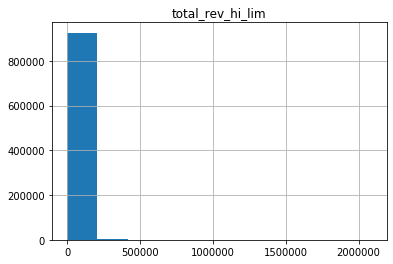

>>> Current breaks:
25000.0,40000.0,50000.0,65000.0 



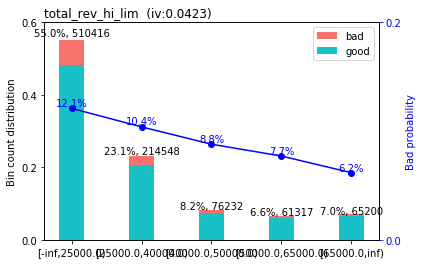

>>> Adjust breaks for (27/28) total_rev_hi_lim?
1: next 
2: yes 
3: back
Selection: 1
-------- 28/28 zip_code --------
>>> dt[zip_code].describe(): 
count     927713
unique        10
top            9
freq      176503
Name: zip_code, dtype: object 

>>> dt[zip_code].value_counts(): 
9    176503
3    126255
1    112827
7     98701
2     88237
0     84371
4     75950
8     70368
6     60883
5     33618
Name: zip_code, dtype: int64 

>>> Current breaks:
'6','0%,%8%,%5','9%,%4%,%2','3','7%,%1' 



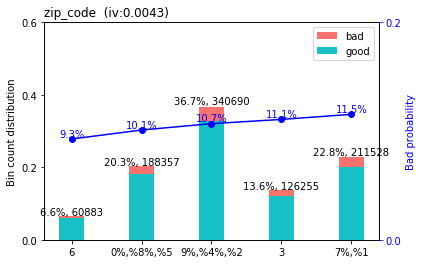

>>> Adjust breaks for (28/28) zip_code?
1: next 
2: yes 
3: back
Selection: 1


In [ ]:
breaks_adj = sc.woebin_adj(train, "loan_status", bins)

In [ ]:
bins_adj = sc.woebin(train, y="loan_status", breaks_list=breaks_adj) # Apply new cuts
train_woe = sc.woebin_ply(train, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...
Binning on 927713 rows and 55 columns in 00:02:54
[INFO] converting into woe values ...
Woe transformating on 927713 rows and 54 columns in 00:02:08
[INFO] converting into woe values ...
Woe transformating on 477914 rows and 54 columns in 00:01:11


In [ ]:
train_woe.head()

,loan_status,emp_length_woe,annual_inc_woe,all_util_woe,inq_fi_woe,debt_settlement_flag_woe,delinq_amnt_woe,hardship_amount_woe,chargeoff_within_12_mths_woe,num_actv_bc_tl_woe,hardship_flag_woe,last_credit_pull_d_woe,mths_since_last_record_woe,open_rv_24m_woe,num_tl_op_past_12m_woe,open_act_il_woe,pub_rec_bankruptcies_woe,application_type_woe,total_cu_tl_woe,last_fico_range_low_woe,num_tl_90g_dpd_24m_woe,mort_acc_woe,total_il_high_credit_limit_woe,mo_sin_rcnt_rev_tl_op_woe,num_accts_ever_120_pd_woe,tot_hi_cred_lim_woe,mo_sin_old_rev_tl_op_woe,total_pymnt_woe,acc_now_delinq_woe,home_ownership_woe,total_bc_limit_woe,purpose_woe,dti_woe,collections_12_mths_ex_med_woe,tax_liens_woe,tot_cur_bal_woe,mths_since_recent_revol_delinq_woe,percent_bc_gt_75_woe,open_il_24m_woe,total_acc_woe,out_prncp_woe,loan_amnt_woe,mths_since_last_major_derog_woe,inq_last_6mths_woe,total_rev_hi_lim_woe,earliest_cr_line_woe,num_tl_120dpd_2m_woe,zip_code_woe,tot_coll_amt_woe,term_woe,total_rec_int_woe,num_op_rev_tl_woe,max_bal_bc_woe,delinq_2yrs_woe,mths_since_recent_inq_woe
0,0,-0.033730,0.121353,-0.735615,-0.060631,0.0,0.0,0.0,0.0,-0.073003,0.0,-0.345257,-0.036570,-0.038696,0.323837,-0.218312,-0.018218,0.028490,-0.302708,2.897998,0.0,-0.010668,0.020176,0.201334,0.108227,-0.018317,0.128288,0.294120,0.0,-0.147640,0.219501,0.103122,-0.318086,0.0,0.0,-0.044536,0.035193,-0.340270,-0.453978,-0.019454,0.51508,-0.396164,0.163517,0.171205,0.135890,0.070292,0.0,0.083011,0.0,-0.193234,-0.249450,-0.152545,-0.229861,-0.031769,0.163092
2,0,-0.033730,-0.005652,-0.074370,-0.060631,0.0,0.0,0.0,0.0,-0.073003,0.0,-0.345257,-0.036570,-0.412297,-0.379474,-0.411086,-0.018218,-0.628626,-0.214143,-3.008662,0.0,-0.170350,0.020176,0.027545,-0.036939,-0.188764,-0.052594,-0.796316,0.0,-0.147640,0.219501,-0.223365,-0.089995,0.0,0.0,-0.044536,-0.037951,0.113897,0.091101,-0.019454,0.51508,0.117081,-0.042272,-0.165377,0.135890,0.070292,0.0,-0.161607,0.0,0.400099,0.137304,-0.152545,-0.229861,-0.031769,0.015339
5,0,0.001594,0.121353,-0.074370,-0.373631,0.0,0.0,0.0,0.0,-0.073003,0.0,1.249359,-0.036570,-0.664759,-0.379474,-0.411086,-0.018218,0.028490,-0.321303,-3.008662,0.0,0.099333,-0.109154,-0.252150,-0.036939,0.128809,0.057990,-0.129344,0.0,0.135356,0.219501,0.103122,-0.089995,0.0,0.0,0.097414,-0.037951,0.253509,-0.453978,-0.293907,0.51508,-0.045011,-0.042272,-0.165377,0.135890,-0.058088,0.0,0.036261,0.0,-0.193234,-0.044544,-0.152545,-0.229861,-0.031769,-0.435885
7,0,-0.033730,-0.005652,-0.430728,-0.373631,0.0,0.0,0.0,0.0,-0.073003,0.0,-0.345257,-0.036570,-0.664759,-0.379474,-0.218312,-0.018218,0.028490,-0.321303,-0.936299,0.0,-0.170350,0.041912,-0.252150,0.137933,-0.018317,0.057990,-0.796316,0.0,-0.147640,0.091938,-0.007999,-0.089995,0.0,0.0,-0.044536,-0.037951,-0.340270,0.091101,-0.019454,0.51508,0.117081,0.163517,-0.165377,0.135890,0.070292,0.0,-0.003809,0.0,-0.193234,-0.044544,-0.152545,-0.229861,0.108735,0.015339
8,0,0.001594,-0.005652,-0.430728,-0.060631,0.0,0.0,0.0,0.0,0.123921,0.0,-0.345257,0.103684,-0.038696,0.066198,-0.411086,0.135531,0.028490,-0.321303,-3.008662,0.0,-0.010668,0.041912,0.201334,-0.036939,0.128809,0.128288,-0.129344,0.0,0.135356,-0.032020,-0.223365,-0.089995,0.0,0.0,0.097414,-0.037951,-0.088426,-0.453978,0.072383,0.51508,-0.045011,-0.042272,0.171205,-0.035336,0.070292,0.0,0.083011,0.0,-0.193234,-0.249450,0.158056,-0.229861,-0.031769,0.318642


In [ ]:
sc.iv(train_woe, 'loan_status')

,variable,info_value
16,last_fico_range_low_woe,4.071438
6,out_prncp_woe,0.811687
14,last_credit_pull_d_woe,0.406819
19,total_pymnt_woe,0.215189
27,all_util_woe,0.156401
42,open_rv_24m_woe,0.151765
38,open_il_24m_woe,0.146334
11,inq_fi_woe,0.130523
22,max_bal_bc_woe,0.127302
18,open_act_il_woe,0.124997


In [ ]:
IV = sc.iv(train_woe, 'loan_status')

In [ ]:
list(IV.iloc[0:11,0].str[:-4])

['last_fico_range_low',
 'out_prncp',
 'last_credit_pull_d',
 'total_pymnt',
 'all_util',
 'open_rv_24m',
 'open_il_24m',
 'inq_fi',
 'max_bal_bc',
 'open_act_il',
 'total_cu_tl']

In [ ]:
feature = list(IV.iloc[0:14,0].str[:-4])

## Variable Selection 

Although "out_prncp" and "total_pymnt" has relative high WOE value, but they are the information we would never have when some applicants come and apply for loans.

So My decison is drop "out_prncp" and "total_pymnt". 

At the same time, the variable "last_fico_range_low" has exordinary value for WOE exceed 1.0. This is because fico is one of the largest credit bureal in the United States, it has much more large sample than we do, and the fico score already a result of modelling result. I am going to include it in my model just in case we need its strong predictive power, and will compare the prediction power between has FICO and without FICO

In [ ]:
train_woe.columns

Index(['loan_status', 'emp_length_woe', 'annual_inc_woe', 'all_util_woe',
       'inq_fi_woe', 'debt_settlement_flag_woe', 'delinq_amnt_woe',
       'hardship_amount_woe', 'chargeoff_within_12_mths_woe',
       'num_actv_bc_tl_woe', 'hardship_flag_woe', 'last_credit_pull_d_woe',
       'mths_since_last_record_woe', 'open_rv_24m_woe',
       'num_tl_op_past_12m_woe', 'open_act_il_woe', 'pub_rec_bankruptcies_woe',
       'application_type_woe', 'total_cu_tl_woe', 'last_fico_range_low_woe',
       'num_tl_90g_dpd_24m_woe', 'mort_acc_woe',
       'total_il_high_credit_limit_woe', 'mo_sin_rcnt_rev_tl_op_woe',
       'num_accts_ever_120_pd_woe', 'tot_hi_cred_lim_woe',
       'mo_sin_old_rev_tl_op_woe', 'total_pymnt_woe', 'acc_now_delinq_woe',
       'home_ownership_woe', 'total_bc_limit_woe', 'purpose_woe', 'dti_woe',
       'collections_12_mths_ex_med_woe', 'tax_liens_woe', 'tot_cur_bal_woe',
       'mths_since_recent_revol_delinq_woe', 'percent_bc_gt_75_woe',
       'open_il_24m_woe', 'tot

In [ ]:
start = 0 
for i in train_woe.columns:
  print(i + '   ' + str(start))
  start = start + 1

loan_status   0
emp_length_woe   1
annual_inc_woe   2
all_util_woe   3
inq_fi_woe   4
debt_settlement_flag_woe   5
delinq_amnt_woe   6
hardship_amount_woe   7
chargeoff_within_12_mths_woe   8
num_actv_bc_tl_woe   9
hardship_flag_woe   10
last_credit_pull_d_woe   11
mths_since_last_record_woe   12
open_rv_24m_woe   13
num_tl_op_past_12m_woe   14
open_act_il_woe   15
pub_rec_bankruptcies_woe   16
application_type_woe   17
total_cu_tl_woe   18
last_fico_range_low_woe   19
num_tl_90g_dpd_24m_woe   20
mort_acc_woe   21
total_il_high_credit_limit_woe   22
mo_sin_rcnt_rev_tl_op_woe   23
num_accts_ever_120_pd_woe   24
tot_hi_cred_lim_woe   25
mo_sin_old_rev_tl_op_woe   26
total_pymnt_woe   27
acc_now_delinq_woe   28
home_ownership_woe   29
total_bc_limit_woe   30
purpose_woe   31
dti_woe   32
collections_12_mths_ex_med_woe   33
tax_liens_woe   34
tot_cur_bal_woe   35
mths_since_recent_revol_delinq_woe   36
percent_bc_gt_75_woe   37
open_il_24m_woe   38
total_acc_woe   39
out_prncp_woe   40
loa

Before we select those features, we check those selected features correlation again.

In [ ]:
df_part6 = Loan_data.loc[:, feature]
corelation_part6 = df_part6.corr(method = 'pearson', min_periods = 1)

In [ ]:
get_top_abs_correlations(corelation_part6, 60)

all_util             open_act_il           0.914356
                     open_il_24m           0.904039
open_il_24m          open_act_il           0.894660
                     inq_fi                0.890037
all_util             inq_fi                0.831911
total_pymnt          open_il_24m           0.782553
                     all_util              0.774970
inq_fi               open_act_il           0.766448
total_pymnt          open_rv_24m           0.757430
                     inq_fi                0.747806
open_rv_24m          open_il_24m           0.746823
                     inq_fi                0.742037
total_pymnt          open_act_il           0.737812
open_il_24m          total_cu_tl           0.735097
all_util             total_cu_tl           0.731160
                     open_rv_24m           0.700415
open_act_il          total_cu_tl           0.657939
total_pymnt          total_cu_tl           0.631431
open_rv_24m          open_act_il           0.629135
inq_fi      

From the above result, we can see we can futher eliminate "all_util" 

In [ ]:
accepted_feature = ([0, 19, 11, 13, 38, 4, 52, 18, 15])

In [ ]:
# Now we create range of accepted variables
train_woe = train_woe.iloc[:, accepted_feature]
test_woe = test_woe.iloc[:, accepted_feature]
train_woe.head()

,loan_status,last_fico_range_low_woe,last_credit_pull_d_woe,open_rv_24m_woe,open_il_24m_woe,inq_fi_woe,max_bal_bc_woe,total_cu_tl_woe,open_act_il_woe
0,0,2.897998,-0.345257,-0.038696,-0.453978,-0.060631,-0.229861,-0.302708,-0.218312
2,0,-3.008662,-0.345257,-0.412297,0.091101,-0.060631,-0.229861,-0.214143,-0.411086
5,0,-3.008662,1.249359,-0.664759,-0.453978,-0.373631,-0.229861,-0.321303,-0.411086
7,0,-0.936299,-0.345257,-0.664759,0.091101,-0.373631,-0.229861,-0.321303,-0.218312
8,0,-3.008662,-0.345257,-0.038696,-0.453978,-0.060631,-0.229861,-0.321303,-0.411086


In [ ]:
#%%script false
train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)
!ls 

In [ ]:
#%%script false
files.download("train_woe.csv")

In [ ]:
#%%script false
files.download("test_woe.csv")

In [ ]:
train_woe['loan_status'].value_counts()

0    828262
1     99451
Name: loan_status, dtype: int64

In [ ]:
train_woe['loan_status'] = train_woe['loan_status'].astype('int')
test_woe['loan_status'] = test_woe['loan_status'].astype('int')

## Perform the Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression

LC_logreg = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=100, 
                                     fit_intercept=True, 
                                     class_weight='balanced',
                                     random_state=251121253, 
                                     max_iter=100, 
                                     verbose=1, 
                                     solver = 'saga',
                                     warm_start=False 
                                    )

In [ ]:
feature_train = train_woe.iloc[:,1:]
objective_train = train_woe['loan_status'] 
feature_test = test_woe.iloc[:,1:]
objective_test = test_woe['loan_status'] 

In [ ]:
LC_logreg.fit(X = feature_train, y = objective_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 10 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s finished


LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=251121253, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
coef_df = pd.concat([pd.DataFrame({'column': train_woe.columns[1:]}), 
                    pd.DataFrame(np.transpose(LC_logreg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,last_fico_range_low_woe,0.986862
1,last_credit_pull_d_woe,0.840228
2,open_rv_24m_woe,0.068714
3,open_il_24m_woe,0.573856
4,inq_fi_woe,-0.084463
5,max_bal_bc_woe,-0.978589
6,total_cu_tl_woe,0.439768
7,open_act_il_woe,0.076973


In [ ]:
LC_logreg.intercept_

array([0.01875087])

In [ ]:
pred_class_test = LC_logreg.predict(feature_test)
probs_test = LC_logreg.predict_proba(feature_test)
print(probs_test[0:5], pred_class_test[0:5])

[[0.80098414 0.19901586]
 [0.72203401 0.27796599]
 [0.95245494 0.04754506]
 [0.07752698 0.92247302]
 [0.95951199 0.04048801]] [0 0 0 1 0]


## Evaluate by Confusion Matrix 

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix_Loan = \
confusion_matrix(y_true = objective_test, y_pred = pred_class_test)

In [ ]:
confusion_matrix_Loan

array([[373283,  53398],
       [  4408,  46825]])

In [ ]:
confusion_matrix_Loan = confusion_matrix_Loan.astype('float') \
            / confusion_matrix_Loan.sum(axis=1)[:, np.newaxis]

In [ ]:
Loan_cm = pd.DataFrame(
        confusion_matrix_Loan, index=['good', 'bad'], columns=['good', 'bad'], 
)

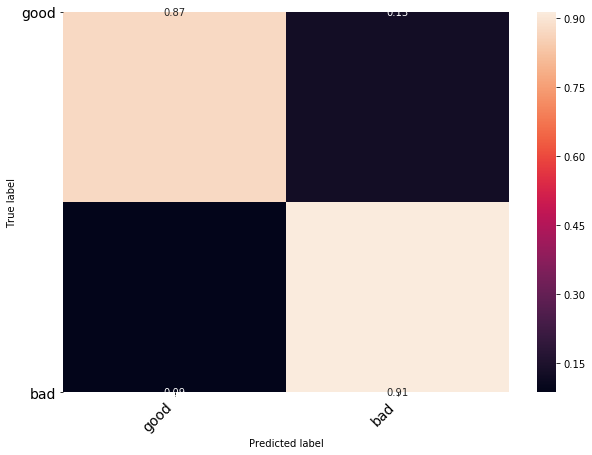

In [ ]:
# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(Loan_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [ ]:
LC_sc = sc.scorecard(bins_adj, LC_logreg, 
             train_woe.columns[1:], # The column names in the trained LR
             points0=500, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 

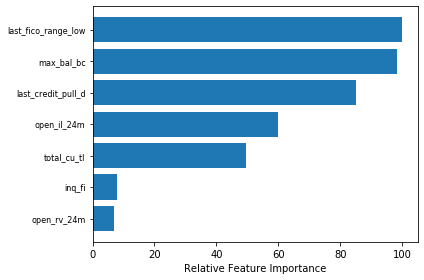

In [ ]:
feature_importance = abs( LC_logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(feature_test.columns.str[:-4])[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

## Scorecard Construction 

In [ ]:
LC_sc

{'basepoints':      variable  bin  points
 0  basepoints  NaN   166.0, 'inq_fi':    variable         bin  points
 12   inq_fi  [-inf,0.0)     3.0
 13   inq_fi   [0.0,2.0)    -2.0
 14   inq_fi   [2.0,inf)    -0.0, 'last_credit_pull_d':               variable              bin  points
 25  last_credit_pull_d    [-inf,2017.0)   -71.0
 26  last_credit_pull_d  [2017.0,2018.0)   -76.0
 27  last_credit_pull_d     [2018.0,inf)    21.0, 'last_fico_range_low':                variable            bin  points
 51  last_fico_range_low   [-inf,580.0)  -206.0
 52  last_fico_range_low  [580.0,640.0)   -92.0
 53  last_fico_range_low  [640.0,680.0)    67.0
 54  last_fico_range_low    [680.0,inf)   214.0, 'max_bal_bc':        variable           bin  points
 163  max_bal_bc    [-inf,0.0)    29.0
 164  max_bal_bc  [0.0,7000.0)   -16.0
 165  max_bal_bc  [7000.0,inf)   -35.0, 'open_act_il':        variable         bin  points
 39  open_act_il  [-inf,0.0)    -2.0
 40  open_act_il   [0.0,2.0)     2.0
 41  open_a

visualize score card

In [ ]:
{'basepoints':      variable    bin       points
        0          basepoints   NaN    166.0, 
 'inq_fi':    variable         bin       points
         17   inq_fi       [-inf,0.0)     2.0
         18   inq_fi        [0.0,2.0)     -2.0
         19    inq_fi       [2.0,inf)    -0.0, 
'last_credit_pull_d':                variable            bin        points
                            114  last_credit_pull_d  [-inf,2018.0)   -74.0
                            115  last_credit_pull_d   [2018.0,inf)    21.0, 
                            
'last_fico_range_low':                variable            bin      points
                           33  last_fico_range_low   [-inf,580.0)  -206.0
                           34  last_fico_range_low  [580.0,640.0)   -92.0
                           35  last_fico_range_low  [640.0,680.0)    67.0
                           36  last_fico_range_low    [680.0,inf)   214.0, 
                                                       
'max_bal_bc':               variable           bin          points
                         146  max_bal_bc    [-inf,0.0)    29.0
                         147  max_bal_bc  [0.0,7000.0)   -16.0
                         148  max_bal_bc  [7000.0,inf)   -35.0, 
'open_act_il':              variable         bin              points
                          69  open_act_il  [-inf,0.0)    -3.0
                          70  open_act_il   [0.0,2.0)     3.0
                          71  open_act_il   [2.0,inf)     1.0, 
'open_il_24m':               variable         bin       points
                          60  open_il_24m  [-inf,0.0)   -17.0
                          61  open_il_24m   [0.0,2.0)    19.0
                          62  open_il_24m   [2.0,3.0)     8.0
                          63  open_il_24m   [3.0,inf)    -4.0, 
                    
'open_rv_24m':               variable         bin        points
                         4   open_rv_24m    [-inf,0.0)      -2.0
                         5  open_rv_24m      [0.0,1.0)      3.0
                         6  open_rv_24m       [1.0,3.0)     2.0
                         7  open_rv_24m       [3.0,inf)      0.0, 
                   
'total_cu_tl':                 variable        bin        points
                     20  total_cu_tl        [-inf,0.0）      -12.0
                     21  total_cu_tl         [0.0,2.0)        9.0
                     22  total_cu_tl          [2.0,3.0)       8.0
                     23  total_cu_tl         [3.0,inf)        6.0}

In [ ]:
train_score = sc.scorecard_ply(train, LC_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(test, LC_sc, 
                               print_step=0)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
train_score.describe()

,score
count,927713.000000
mean,293.433869
std,153.104696
min,-149.000000
25%,251.000000
50%,392.000000
75%,399.000000
max,419.000000


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve



## Evaluate By ROC Curve 

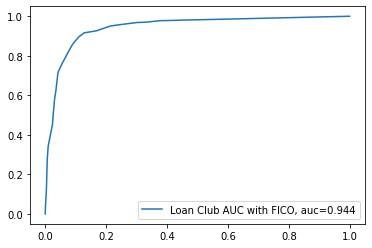

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test['loan_status'].astype('float'), probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test['loan_status'].astype('float'), 
                             y_score = probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Loan Club AUC with FICO, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##Comparison with no FICO score added

Because it is the most important feature of FICO is also a credit score, we will see what would happen if no FICO added

In [ ]:
feature_train_nofico = train_woe.iloc[:,1:]
feature_train_nofico = feature_train_nofico.drop(['last_fico_range_low_woe'], axis = 1)
objective_train_nofico = train_woe['loan_status'] 
feature_test_nofico = test_woe.iloc[:,1:]
feature_test_nofico = feature_test_nofico.drop(['last_fico_range_low_woe'], axis = 1)
objective_test_nofico = test_woe['loan_status'] 

In [ ]:
LC_logreg_nofico = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=100, # Penalty constant, see below
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=251121253, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'saga',
                                     warm_start=False # Train anew or start from previous weights. For repeated training. 
                                    )

In [ ]:
LC_logreg_nofico.fit(X = feature_train_nofico, y = objective_train_nofico)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 37 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.5s finished


LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=251121253, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
LC_logreg_nofico.intercept_

array([0.24818346])

In [ ]:
pred_class_test2 = LC_logreg_nofico.predict(feature_test_nofico)
probs_test2 = LC_logreg_nofico.predict_proba(feature_test_nofico)
print(probs_test[0:5], pred_class_test[0:5])

[[0.80098414 0.19901586]
 [0.72203401 0.27796599]
 [0.95245494 0.04754506]
 [0.07752698 0.92247302]
 [0.95951199 0.04048801]] [0 0 0 1 0]


In [ ]:
confusion_matrix_Loan_nofico = \
confusion_matrix(y_true = objective_test_nofico, y_pred = pred_class_test2)

In [ ]:
confusion_matrix_Loan_nofico = confusion_matrix_Loan_nofico.astype('float') \
            / confusion_matrix_Loan_nofico.sum(axis=1)[:, np.newaxis]

In [ ]:
Loan_cm_nofico = pd.DataFrame(
        confusion_matrix_Loan_nofico, index=['good', 'bad'], columns=['good', 'bad'], 
)

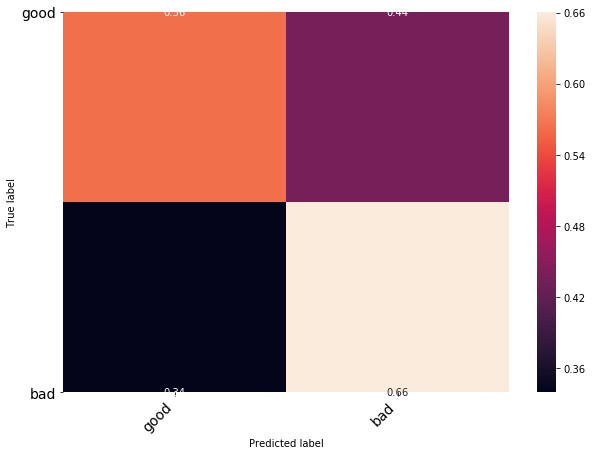

In [ ]:
# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap2 = sns.heatmap(Loan_cm_nofico, annot=True, fmt='.2f')

# Make it nicer
heatmap2.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap2.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

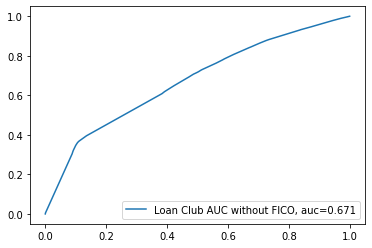

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test['loan_status'].astype('float'), probs_test2[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test['loan_status'].astype('float'), 
                             y_score = probs_test2[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Loan Club AUC without FICO, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Final Comparison betweem scorecard with FICO included and excluded 

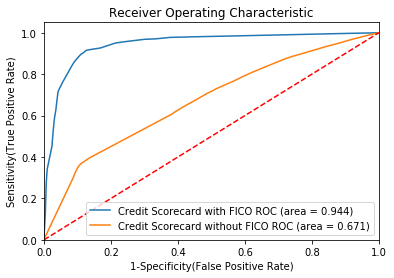

In [ ]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Credit Scorecard with FICO',
    'probs': probs_test[:,1]
},
{
    'label': 'Credit Scorecard without FICO',
    'probs': probs_test2[:,1]
},
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = test['loan_status'].astype('float'), 
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(test['loan_status'].astype('float'), 
                                           m['probs'])
  plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
                 

    
# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
    
# Plot!    
plt.show()